In [ ]:
import covidcast
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import time
import tensorflow as tf

%cd ../code
from model import Model

%cd ../notebooks

In [ ]:
#Load data
start_date = datetime(2020, 9, 15)
end_date = datetime(2020, 12, 15)
    
X_df = covidcast.signal(
        'fb-survey', 
        'smoothed_cli',
        start_date, end_date,
        geo_type='state')

Y_df = covidcast.signal(
        'indicator-combination',
        'confirmed_7dav_incidence_num',
        start_date, end_date,
        geo_type='state')

In [ ]:
#Process data for use in Tensorflow
states = ['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'de', 'fl', 'ga',
       'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me',
       'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm',
       'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
       'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']

df = X_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
X = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
X = tf.transpose(X, perm=[1,0])
X = tf.expand_dims(X,axis=0) #shape=(1,number of geo_values, time series values)
X = tf.cast(X, dtype=tf.float32)

df = Y_df.sort_values(['geo_value', 'time_value'])
df = df[df['geo_value'].isin(states)]
Y = pd.pivot_table(df,index='geo_value',columns=df.groupby(['geo_value']).cumcount().add(1), values='value').values
Y = tf.transpose(Y, perm=[1,0])
Y = tf.expand_dims(Y,axis=0) #shape=(1,number of geo_values, time series values)
Y = tf.cast(Y, dtype=tf.float32)

In [ ]:
#Initialize model

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None
lr = 1

model = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_PATH = "model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

In [ ]:
#Training
start=time.time()
hist = model.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 1000,
    verbose = 0, #Set to 0 if you don't want to show progress bar, set to 1 if you do
)

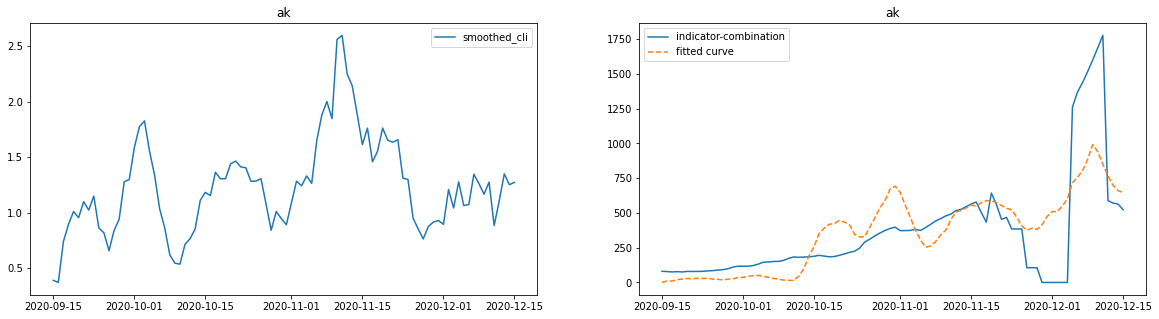

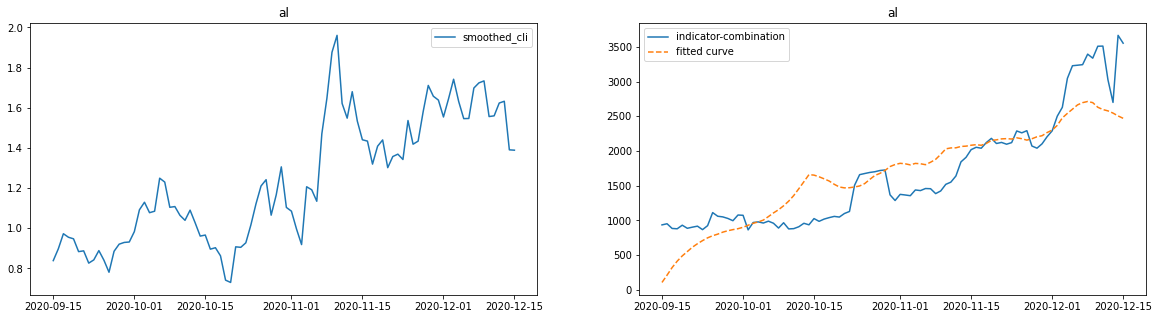

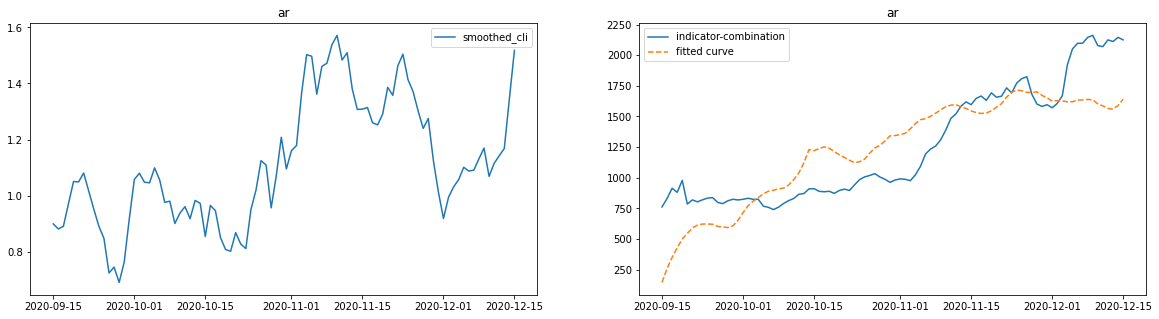

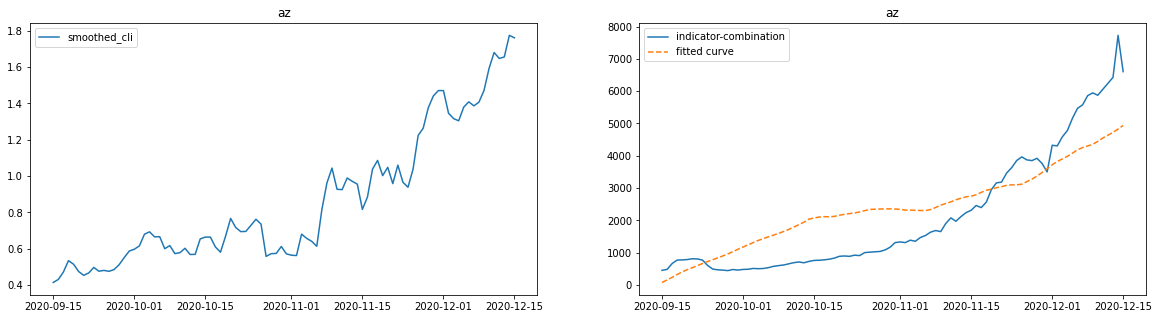

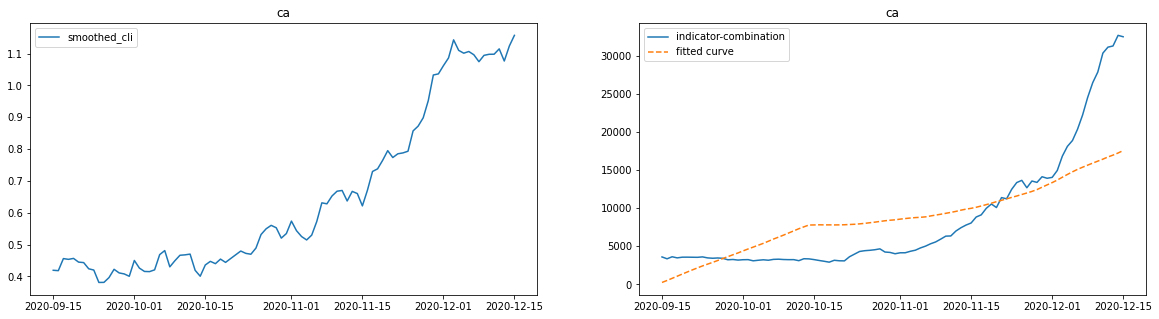

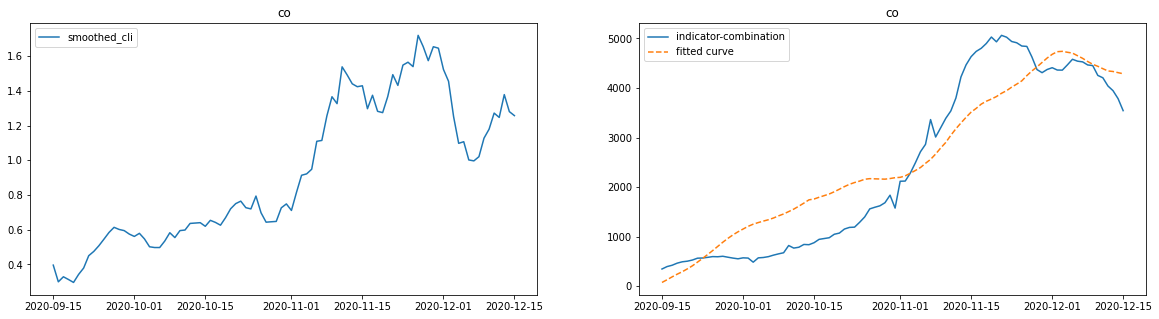

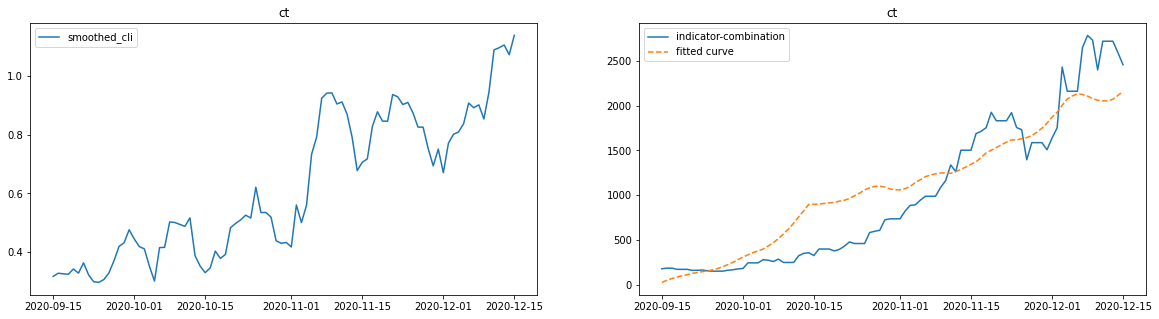

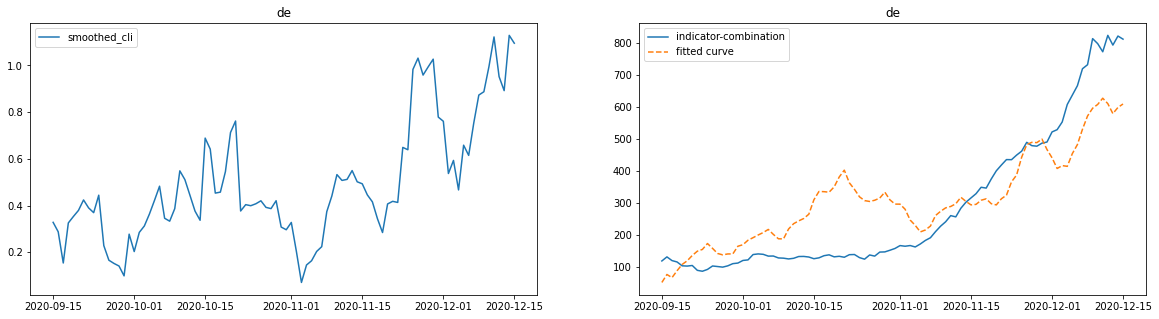

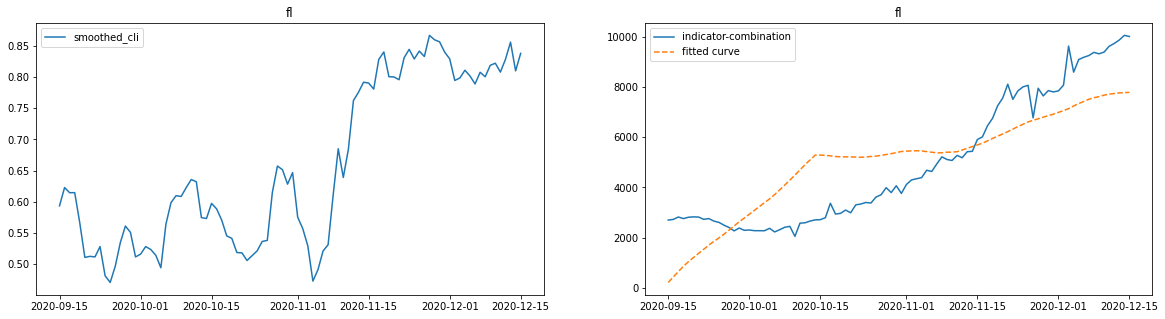

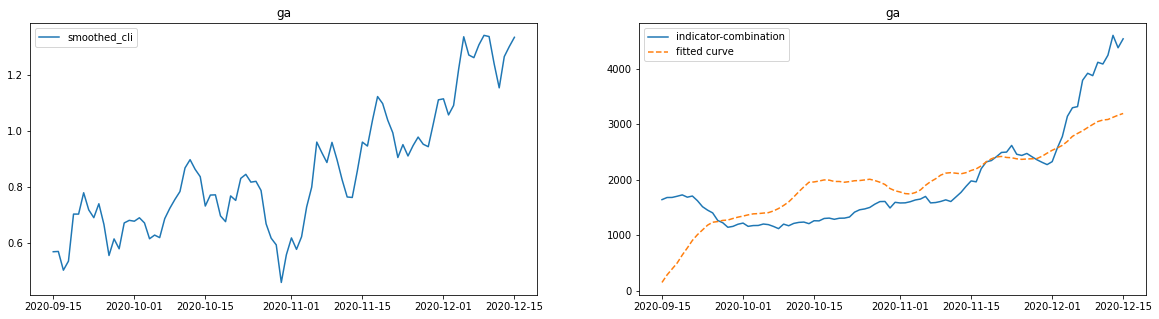

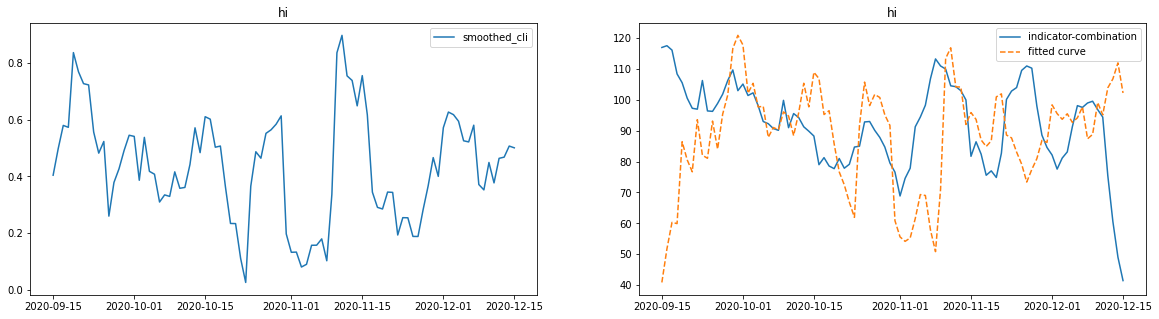

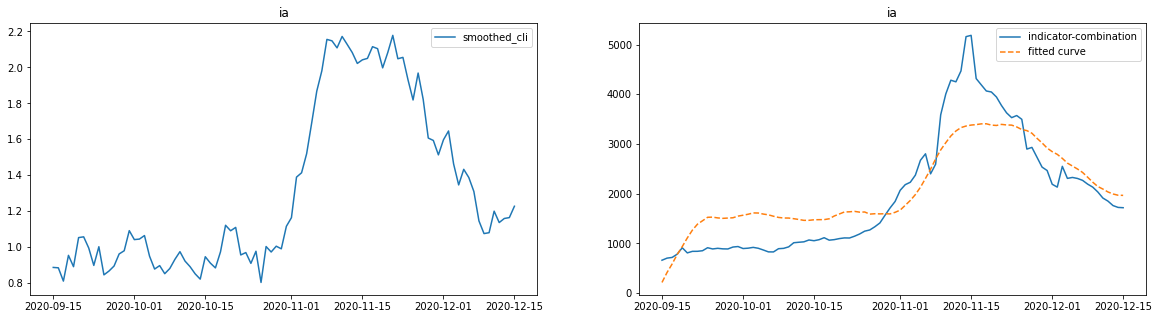

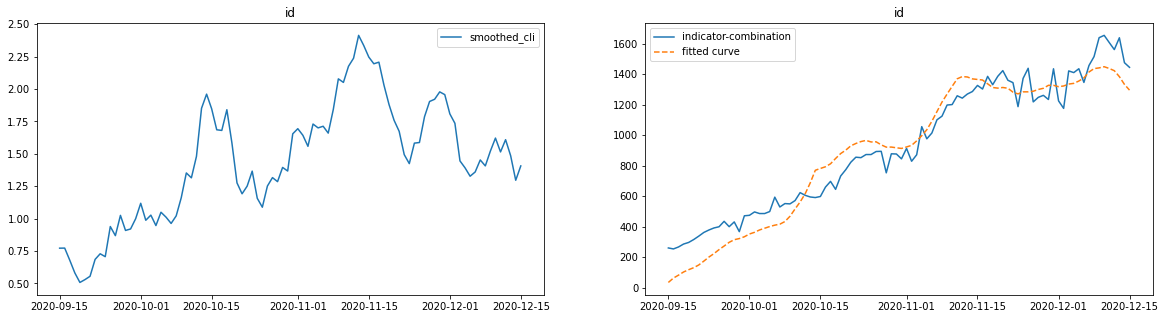

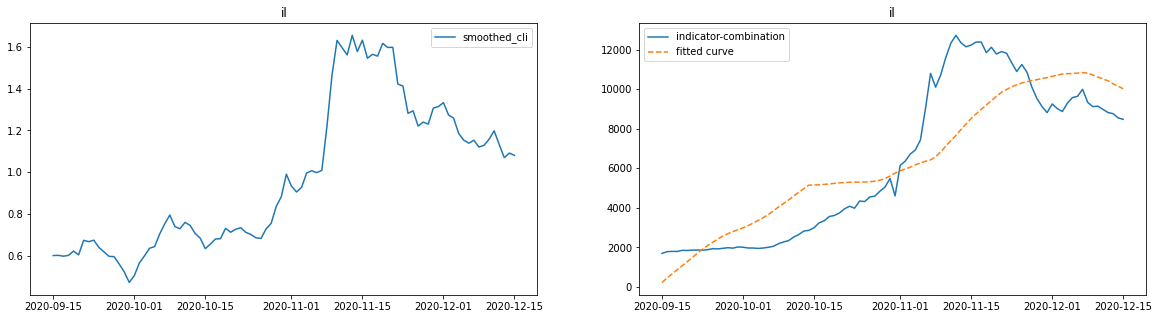

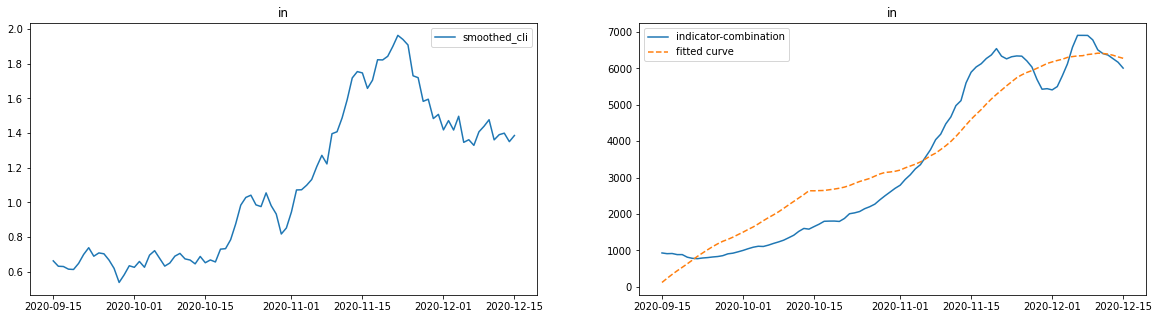

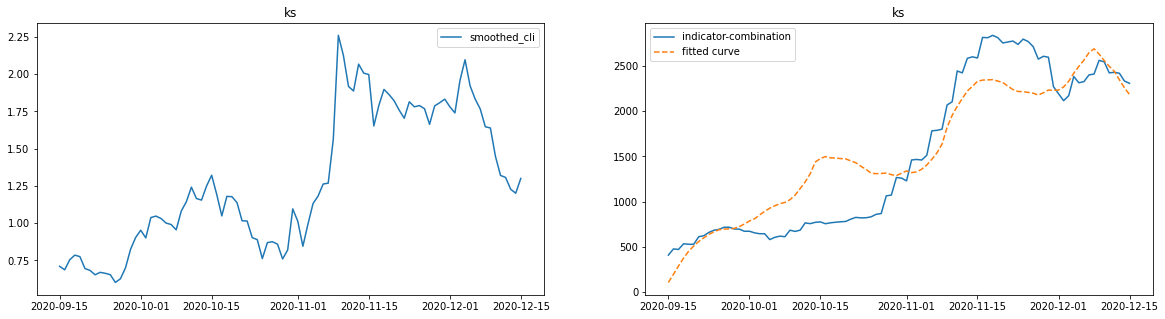

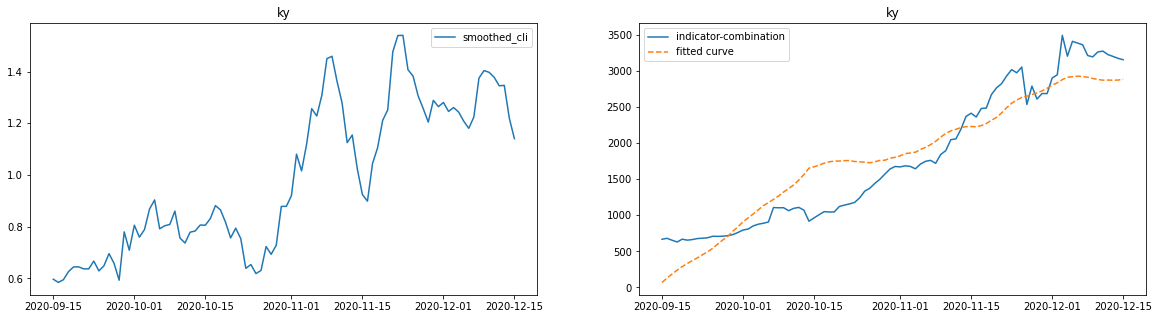

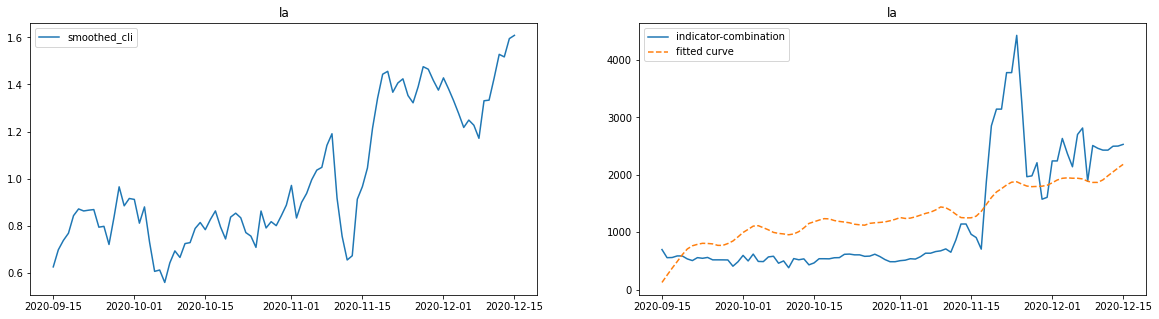

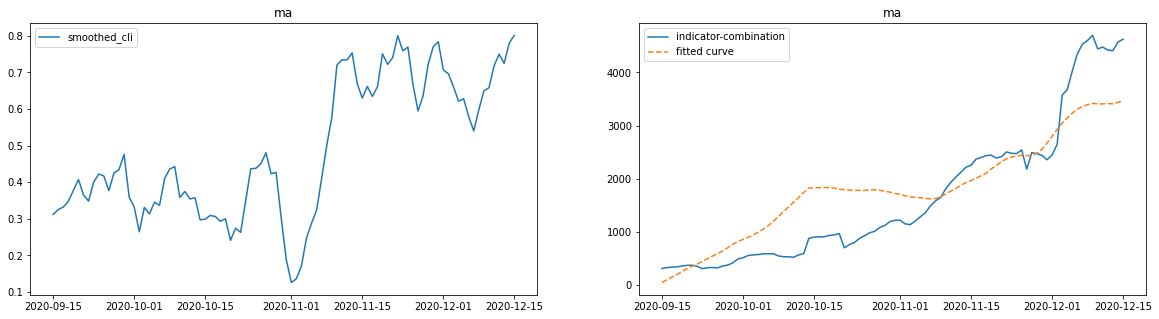

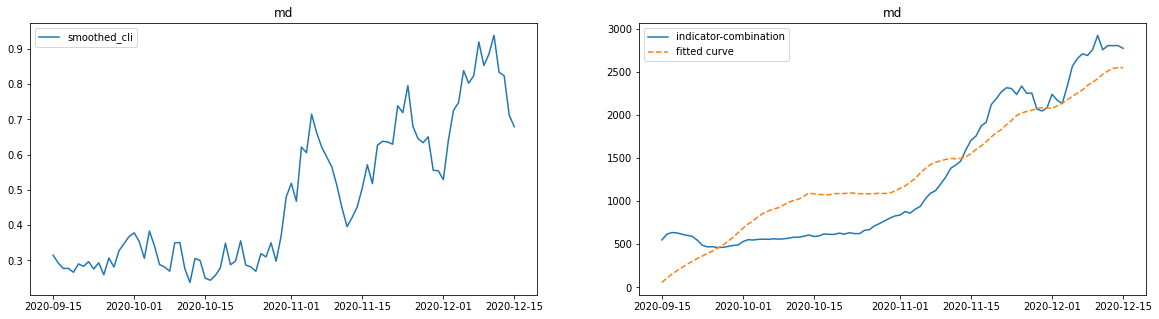

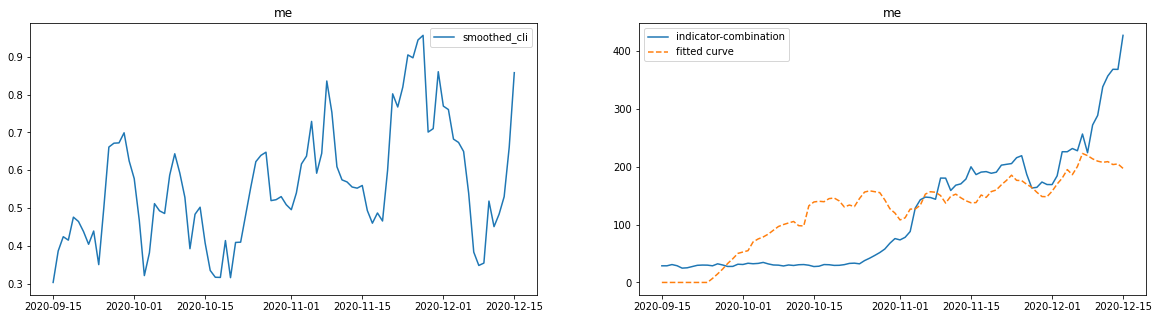

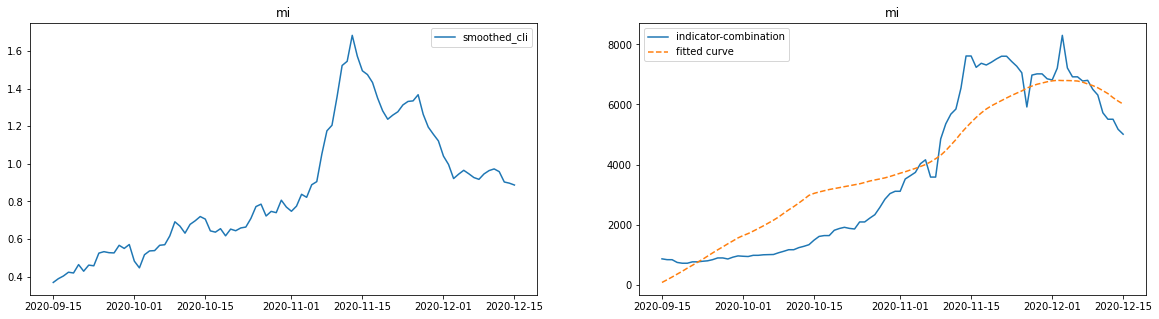

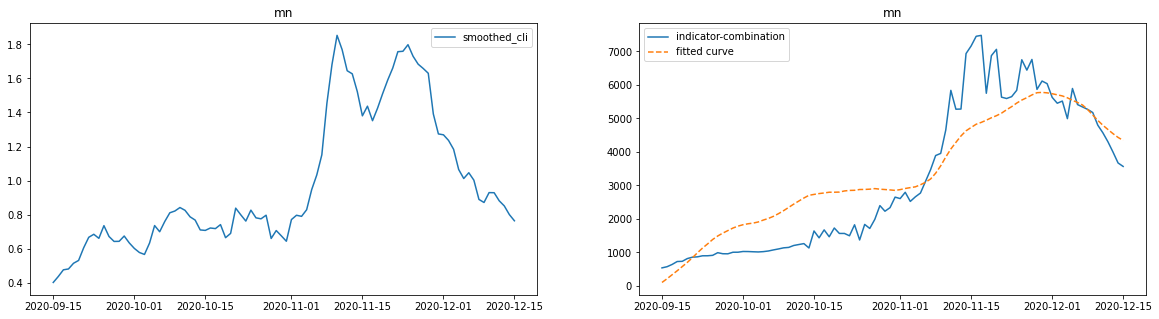

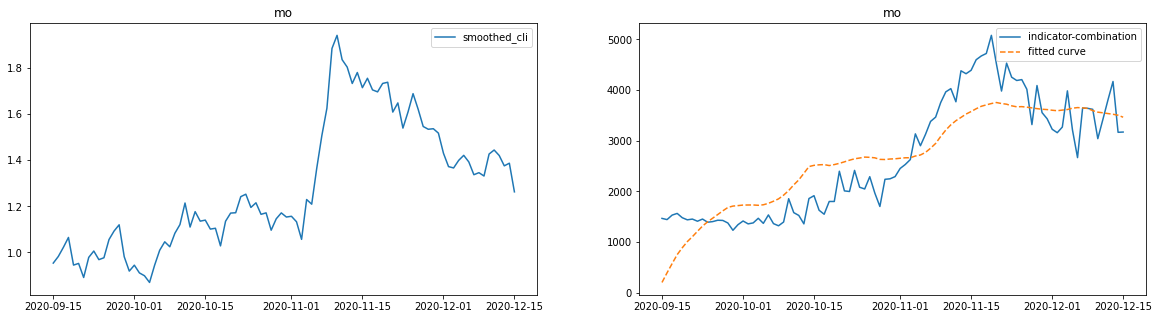

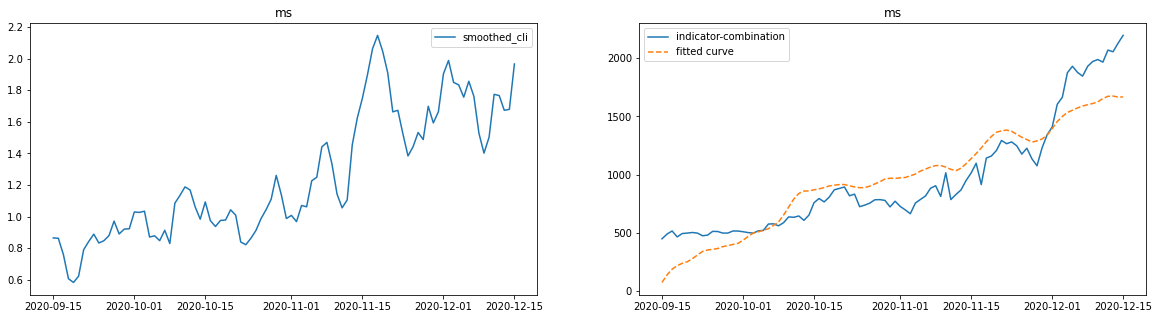

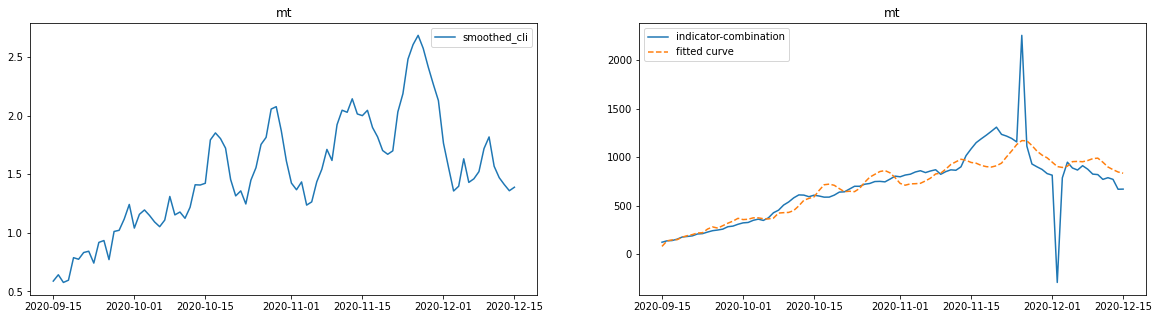

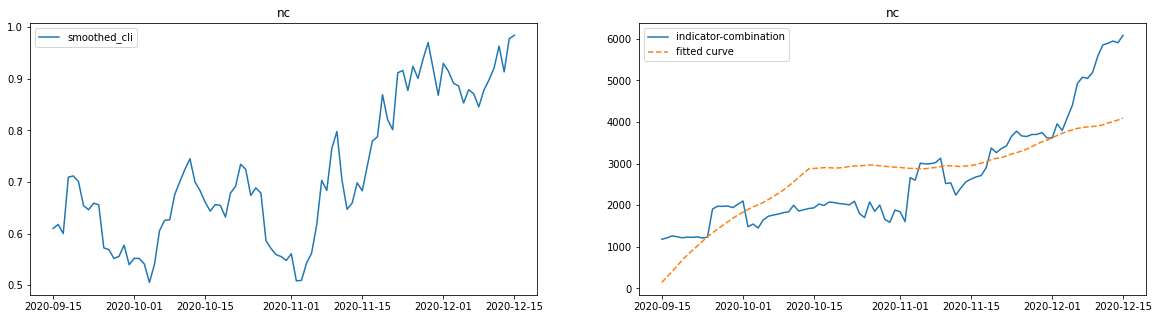

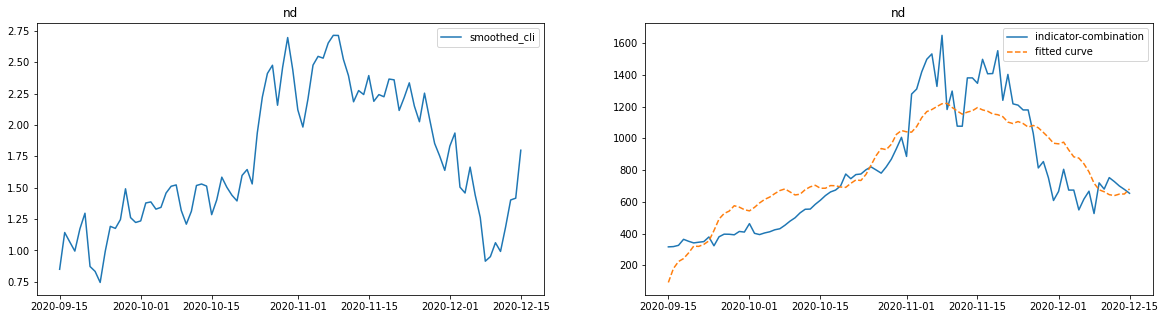

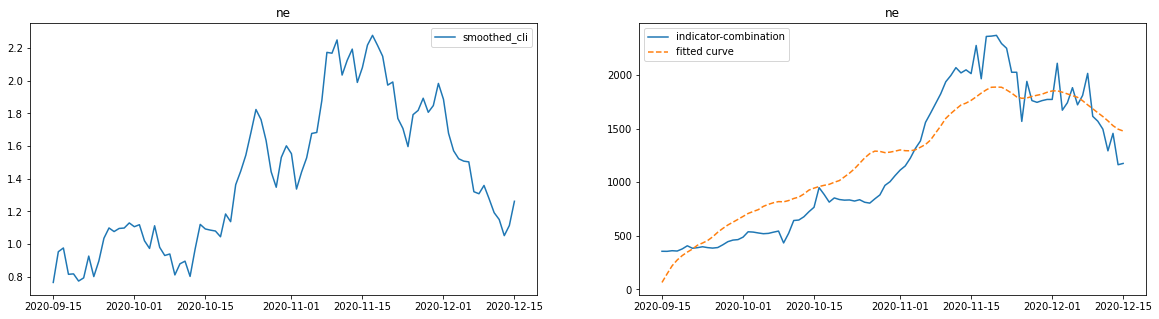

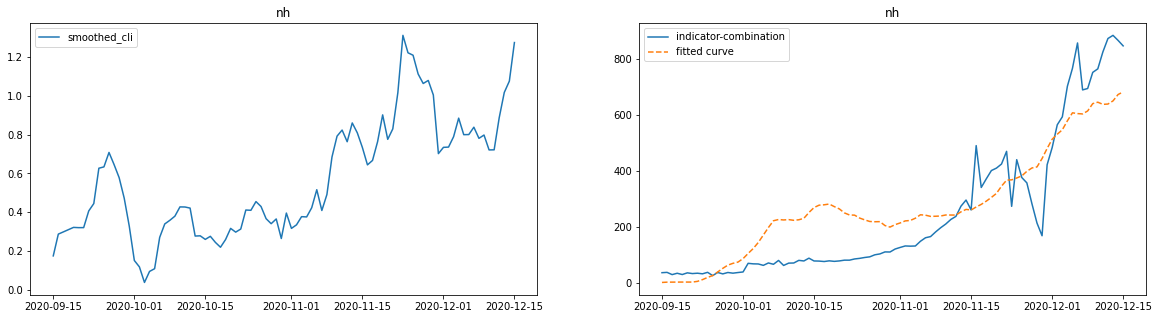

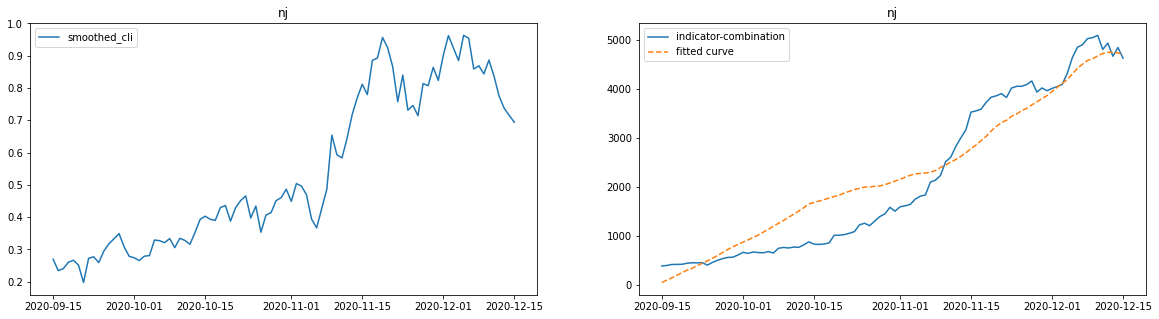

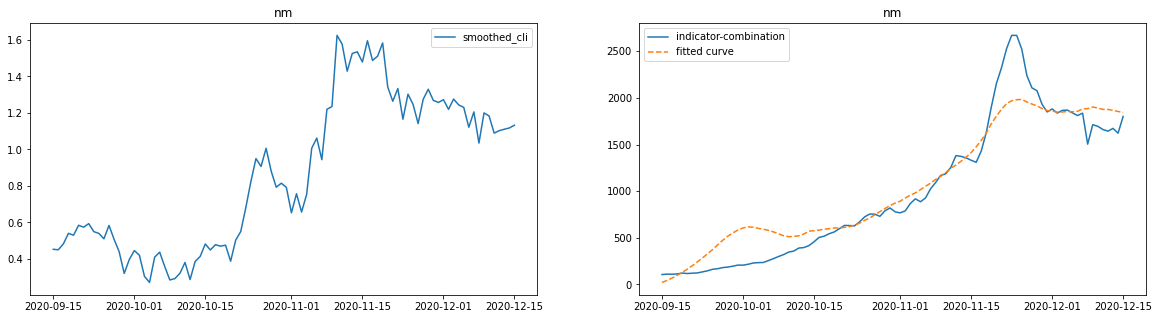

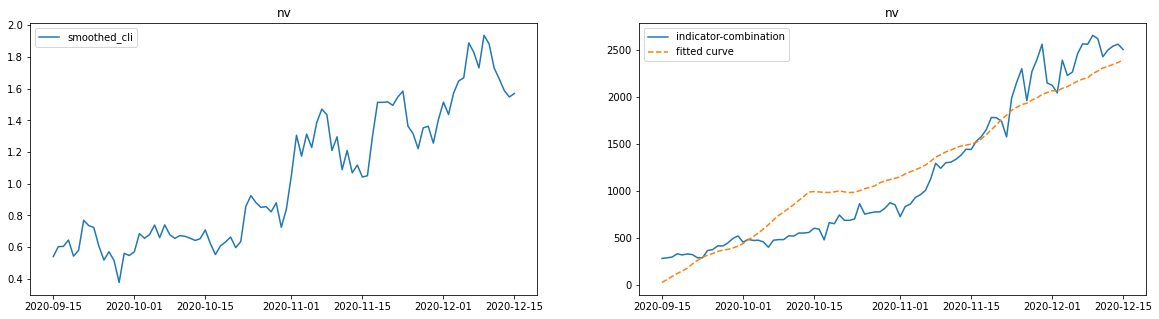

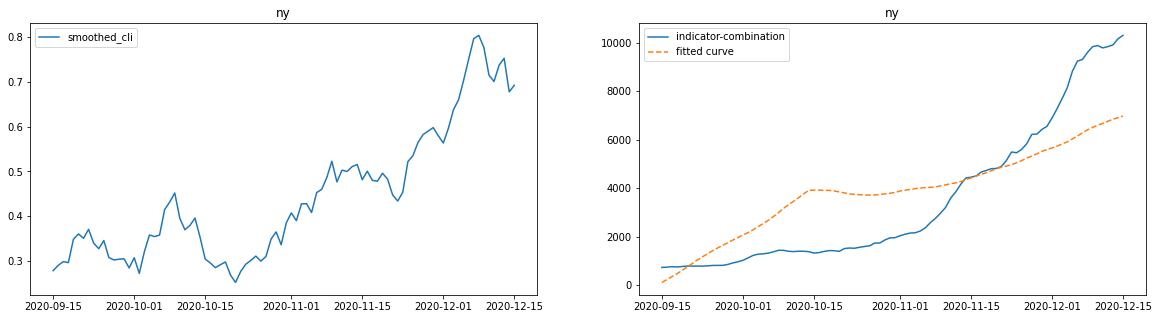

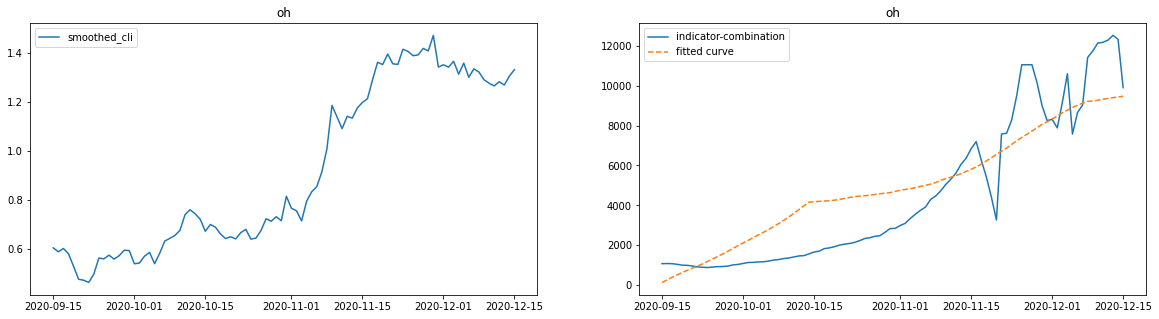

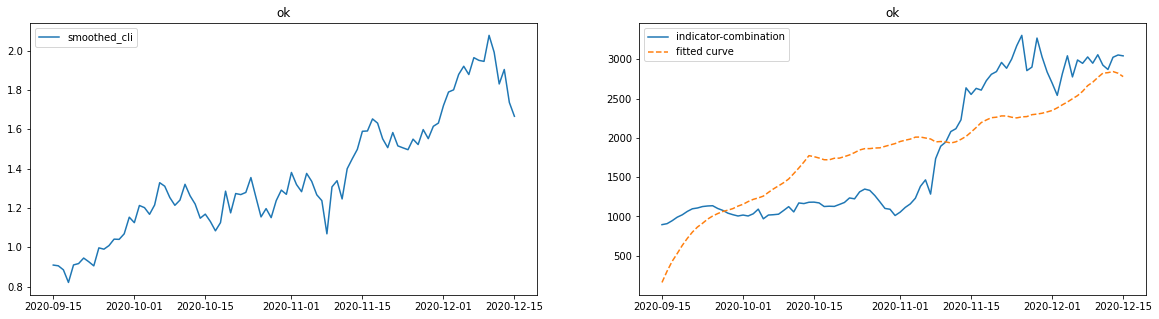

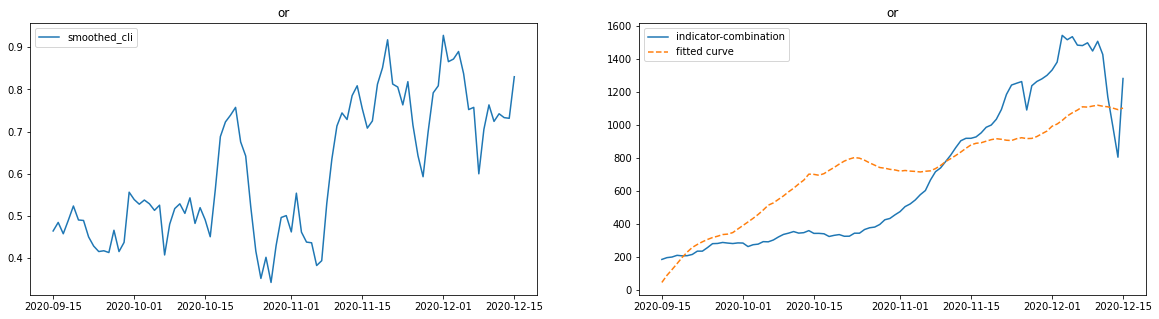

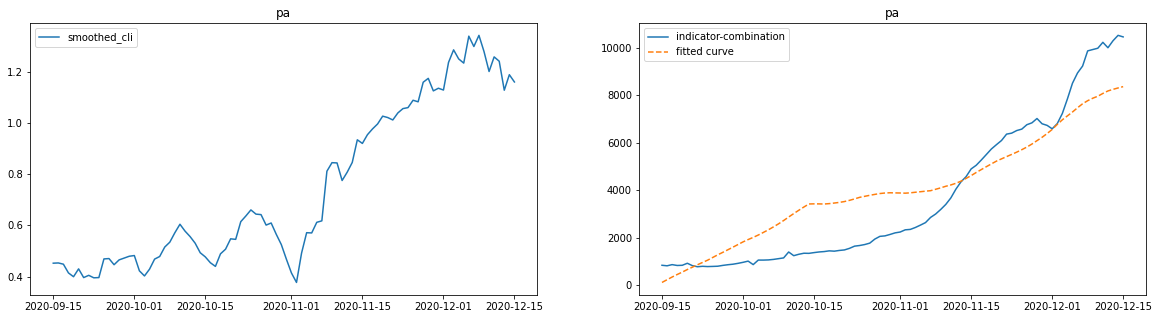

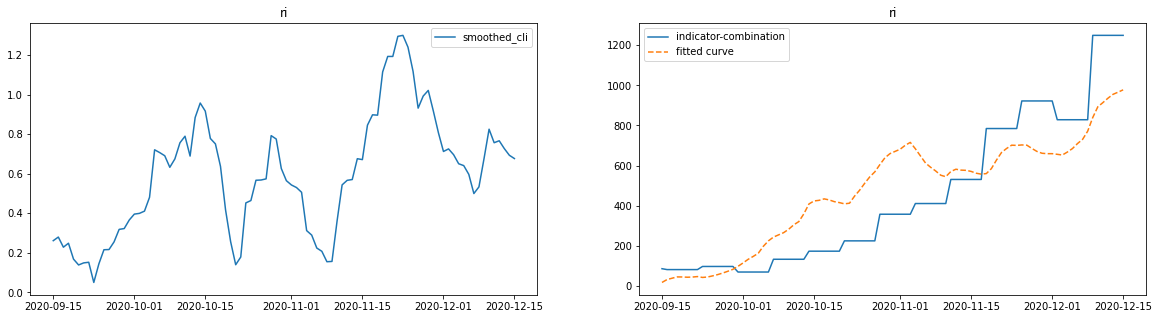

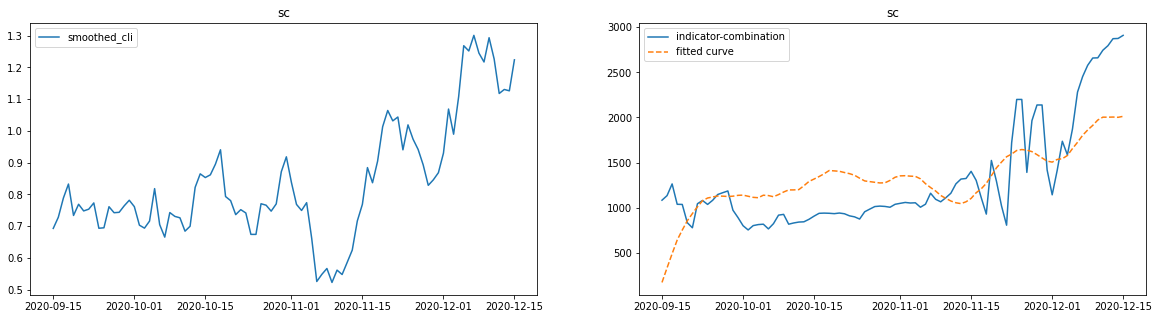

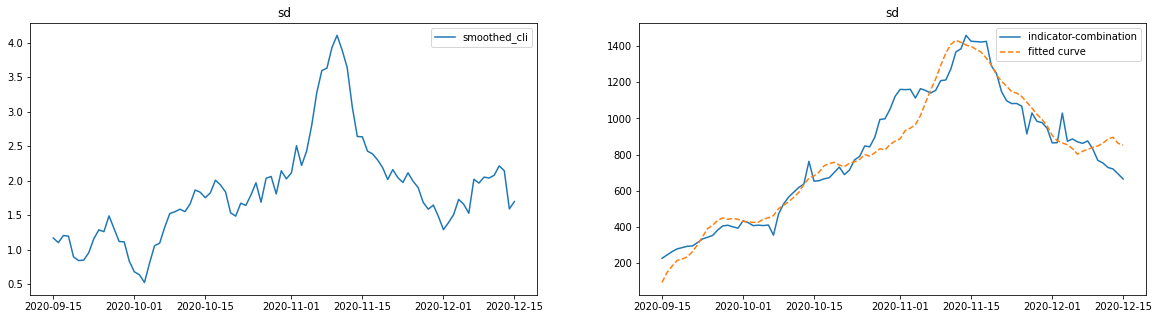

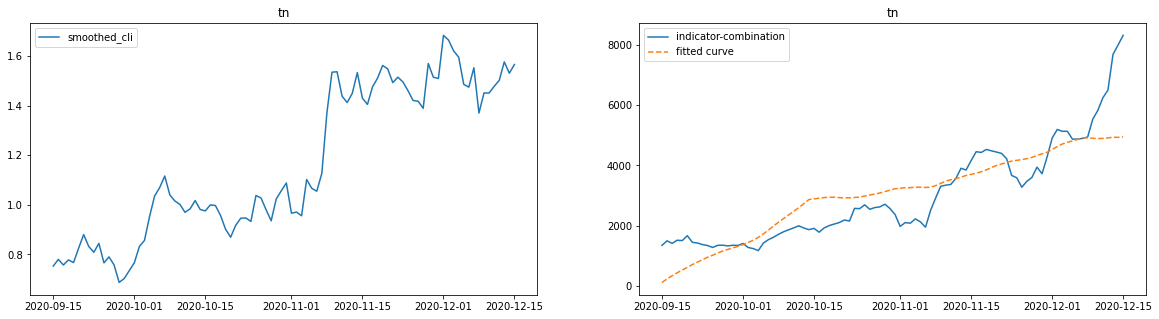

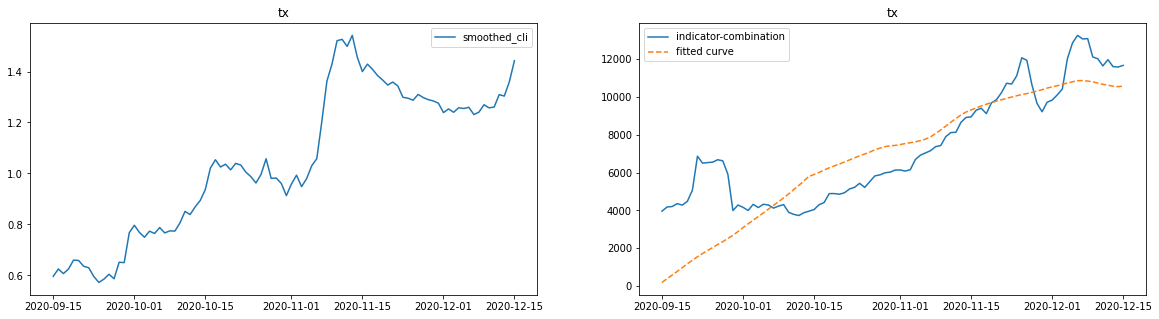

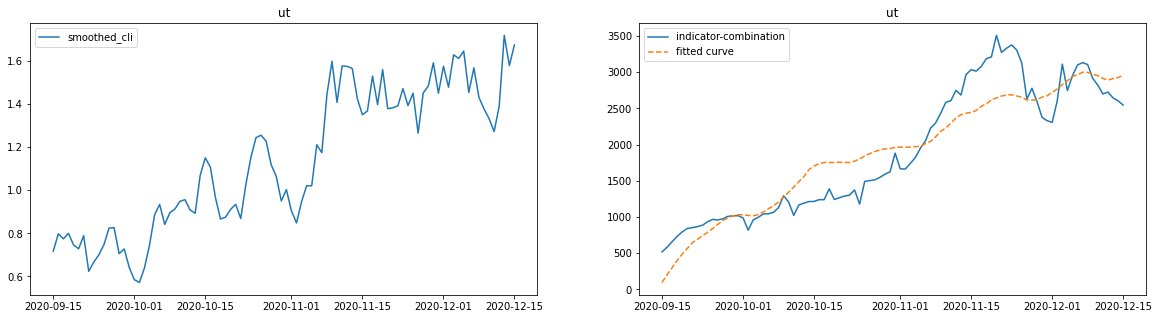

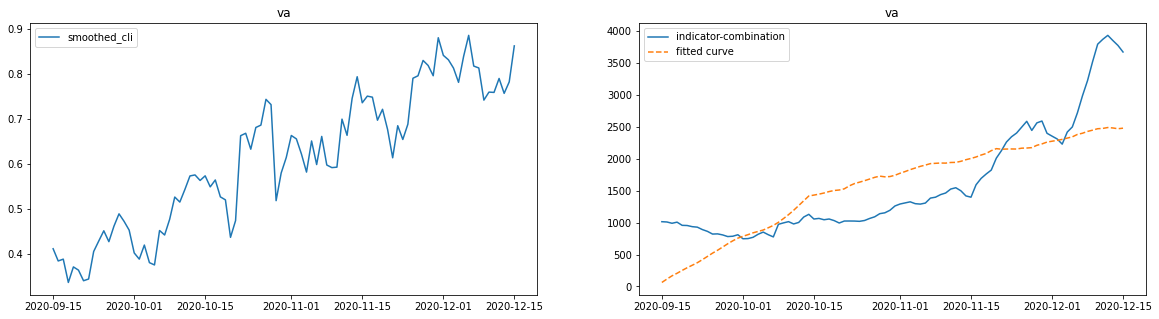

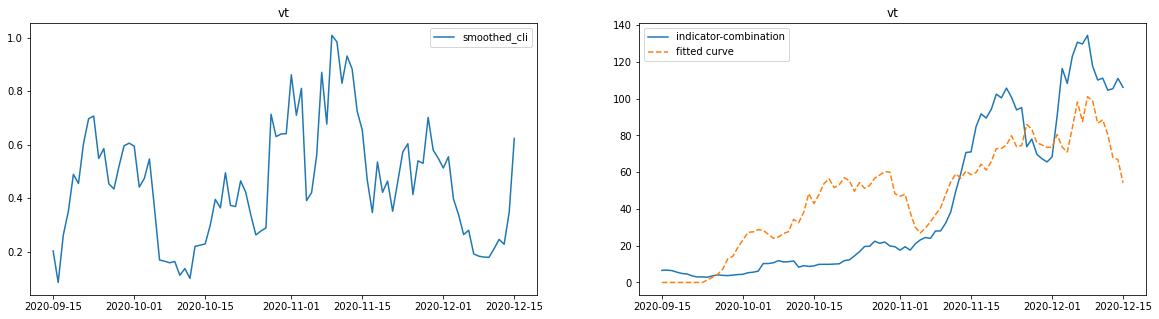

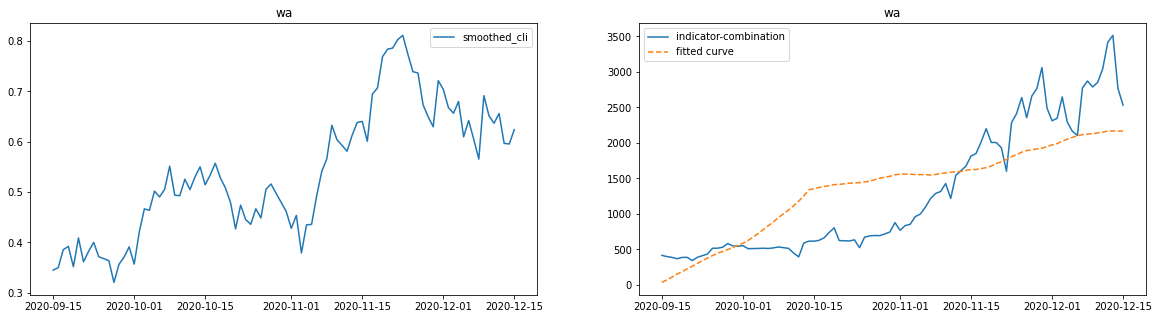

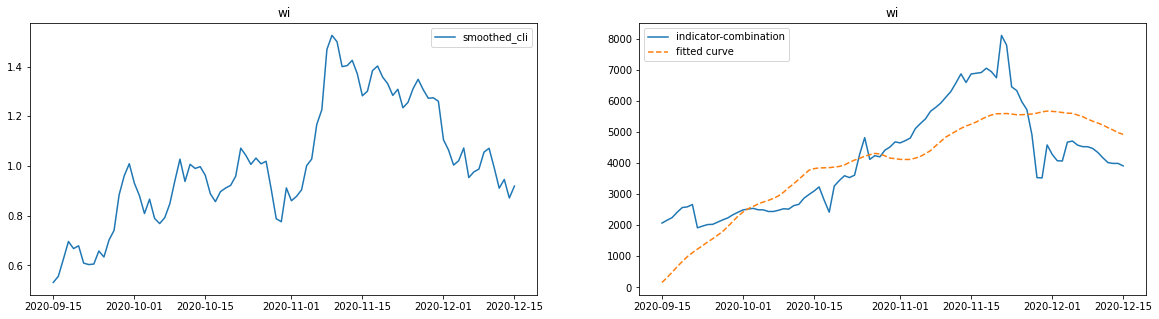

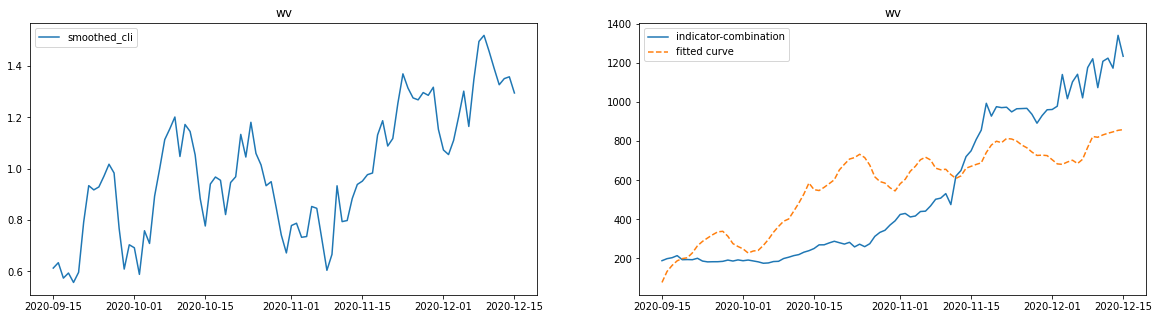

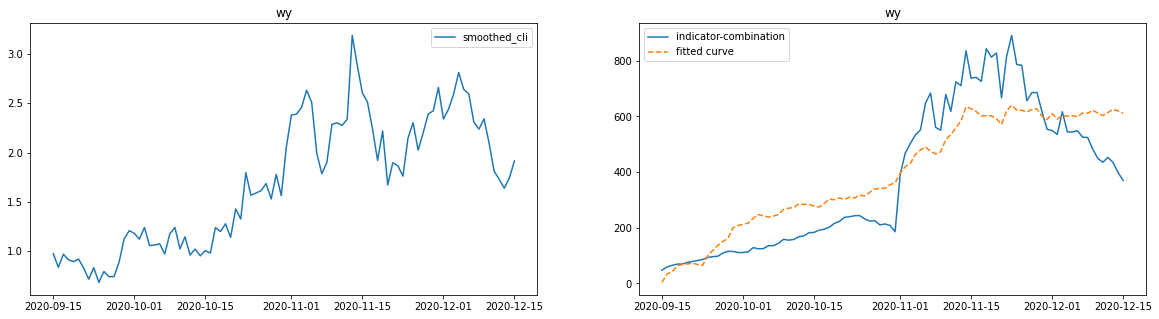

In [9]:
#Evaluation
model.load_weights(MODEL_PATH).expect_partial() #load best weights from training
dates = X_df['time_value'].sort_values().unique()
X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat = model(X_padded)
for i in range(len(states)):
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat = Y_hat[0,:,i]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat, label='fitted curve', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    
    plt.show()

# Check to see if parallel fits coincide with individual fits

In [ ]:
INDEXES=range(50) #Indexes of states we want to fit on

In [ ]:
#Initialize model

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None
lr = 1

model = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

#This just monitors the specified quantity
#and creates a checkpoint when the monitored quantity is 
#lower than the previous recorded value

MODEL_PATH = "model.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = MODEL_PATH,
    verbose = 0,
    monitor = "MSE",
    mode = 'min',
    save_best_only = True,
    save_weights_only = True
)
callbacks = [
    checkpoint_callback,
]

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

#Training
hist = model.fit(
    x = X,
    y = Y,
    callbacks = callbacks,
    epochs = 1000,
    verbose = 0, #Set to 0 if you don't want to show progress bar, set to 1 if you doThe 
)

#Evaluation
model.load_weights(MODEL_PATH).expect_partial() #load best weights from training

X_padded = tf.pad(
    X[:,:,:],
    paddings=[[0, 0], [p-1, 0], [0, 0]],
)
Y_hat = model(X_padded)

In [ ]:
Y_hat_single = {}
for i in INDEXES:
    X_single = X[:,:,i:i+1]
    Y_single = Y[:,:,i:i+1]
    #Initialize model

    #You can apply constraints directly to layers by setting
    #the kernel_constraints parameter for a specific layer
    #
    #https://www.tensorflow.org/api_docs/python/tf/keras/constraints
    p = 30
    m = X_single.shape[2] #number of geo_values
    kernel_constraint = tf.keras.constraints.NonNeg()
    kernel_regularizer = None
    lr = 1

    model = Model(
        p = p, 
        m = m,
        kernel_constraint = kernel_constraint,
        kernel_regularizer = kernel_regularizer,
    )
    optimizer = tf.keras.optimizers.Adam(lr = lr)

    def MSE(y_true, y_pred):
        return tf.reduce_mean((y_true-y_pred)**2)
    loss = MSE

    #This just monitors the specified quantity
    #and creates a checkpoint when the monitored quantity is 
    #lower than the previous recorded value

    MODEL_PATH = "model.ckpt"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH,
        verbose = 0,
        monitor = "MSE",
        mode = 'min',
        save_best_only = True,
        save_weights_only = True
    )
    callbacks = [
        checkpoint_callback,
    ]

    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = [loss],
    )
    #Training
    hist = model.fit(
        x = X_single,
        y = Y_single,
        callbacks = callbacks,
        epochs = 1000,
        verbose = 0 #Set to 0 if you don't want to show progress bar, set to 1 if you do
    )

    #Evaluation
    model.load_weights(MODEL_PATH).expect_partial() #load best weights from training
    X_padded = tf.pad(
        X_single,
        paddings=[[0, 0], [p-1, 0], [0, 0]],
    )
    Y_hat_single[i] = model(X_padded)

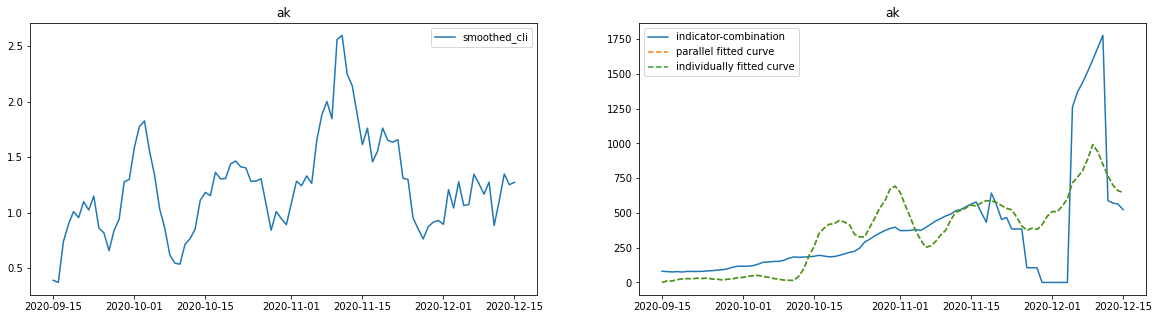

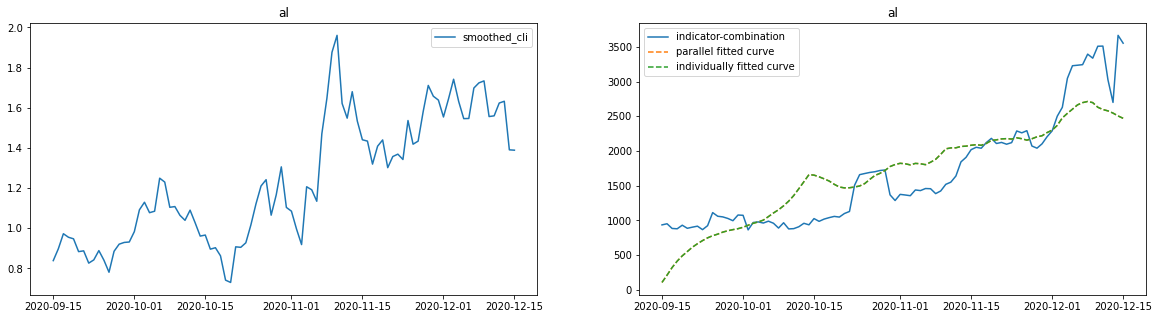

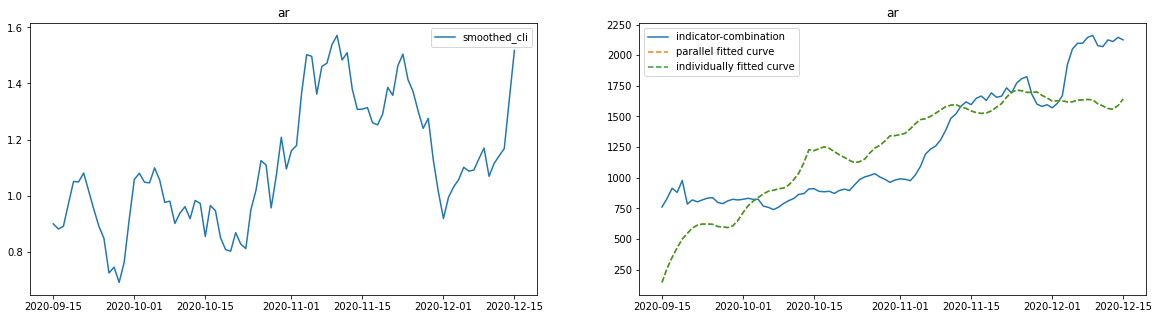

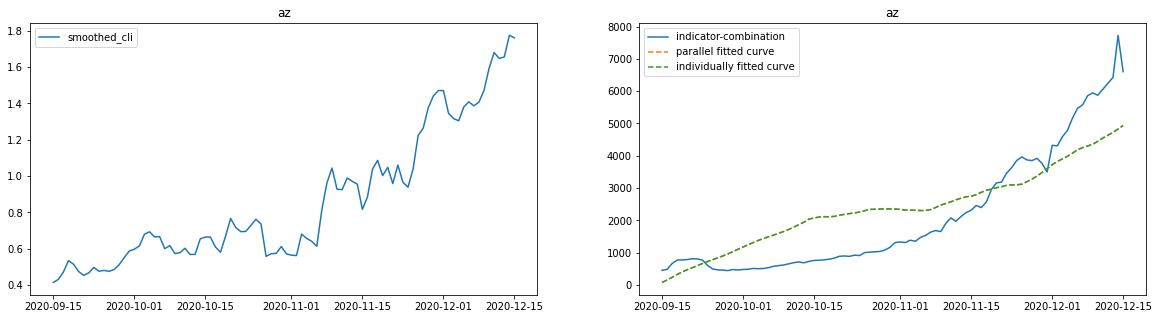

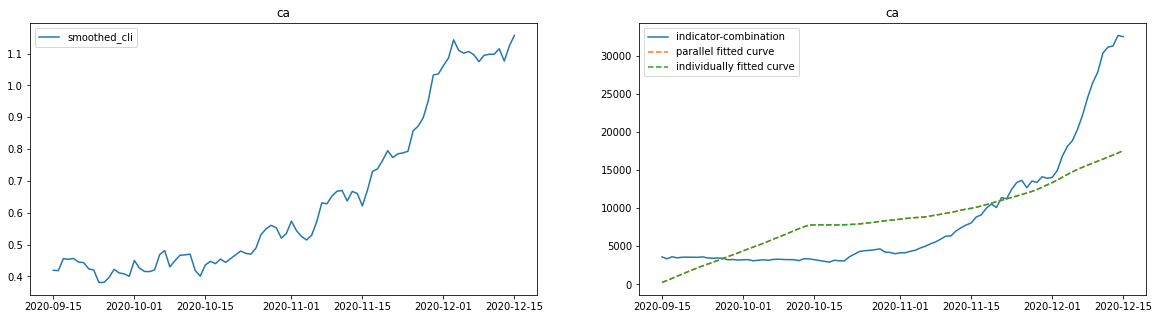

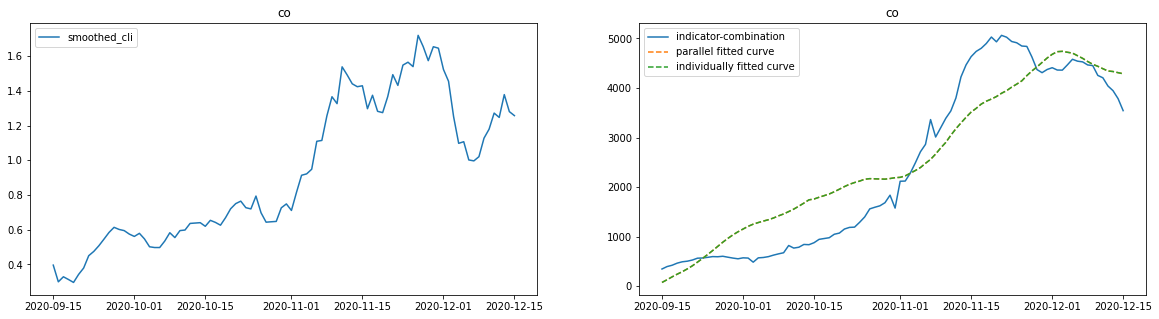

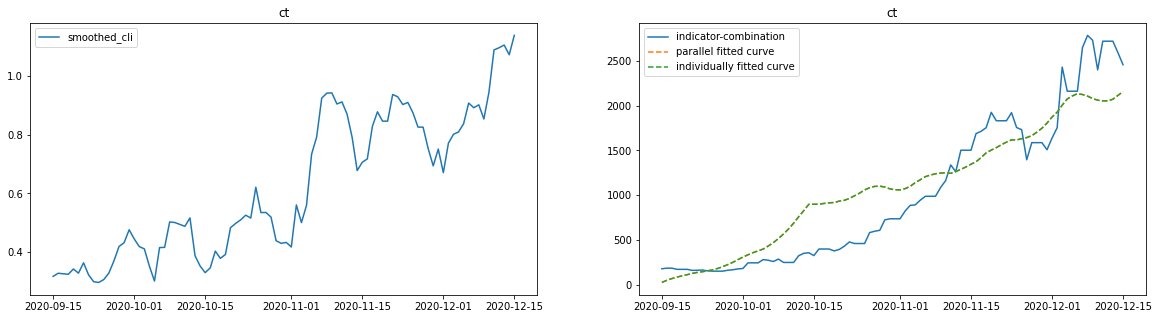

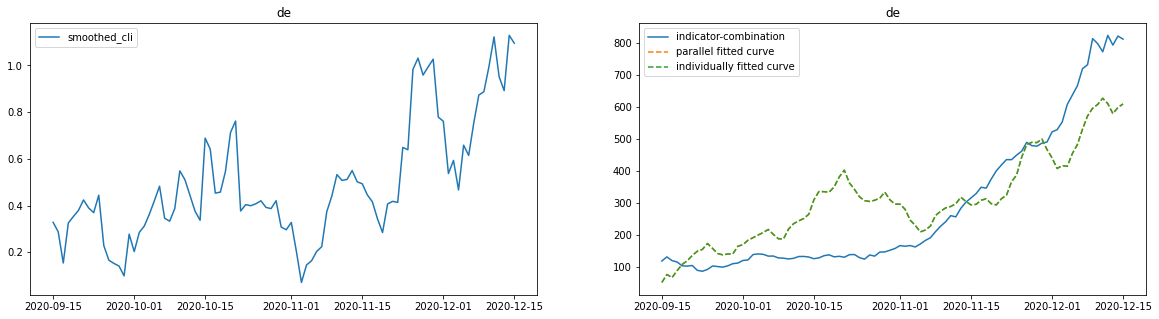

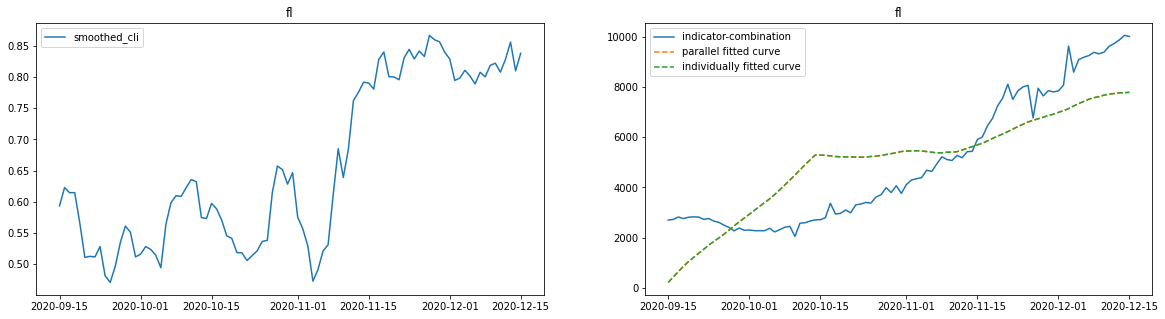

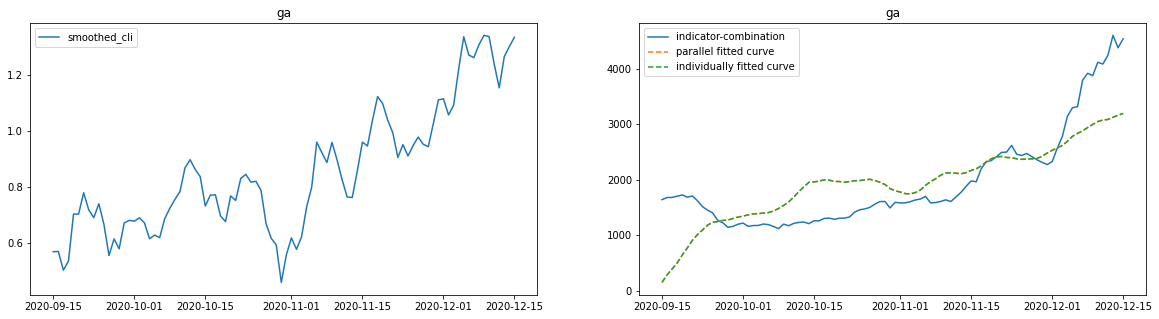

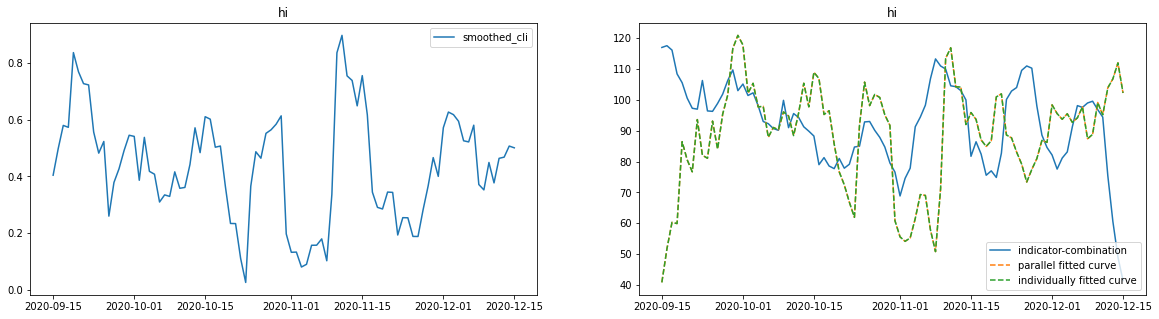

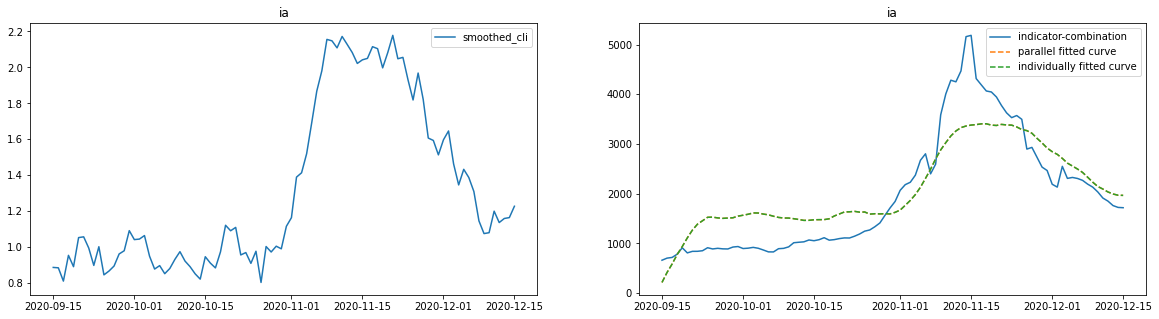

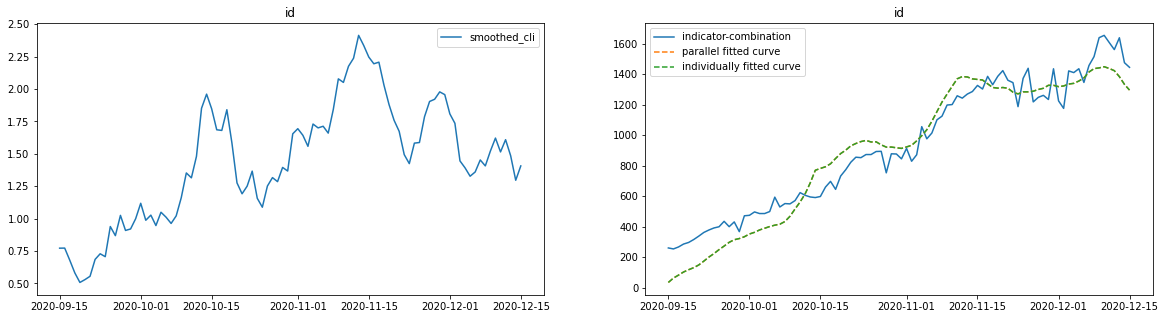

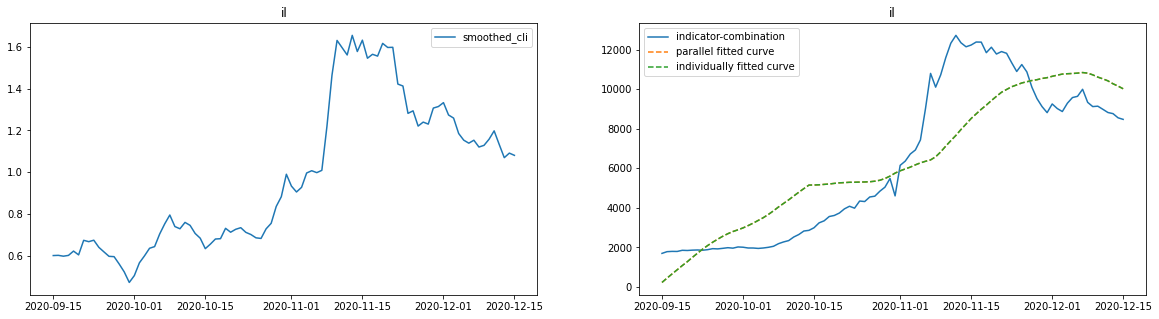

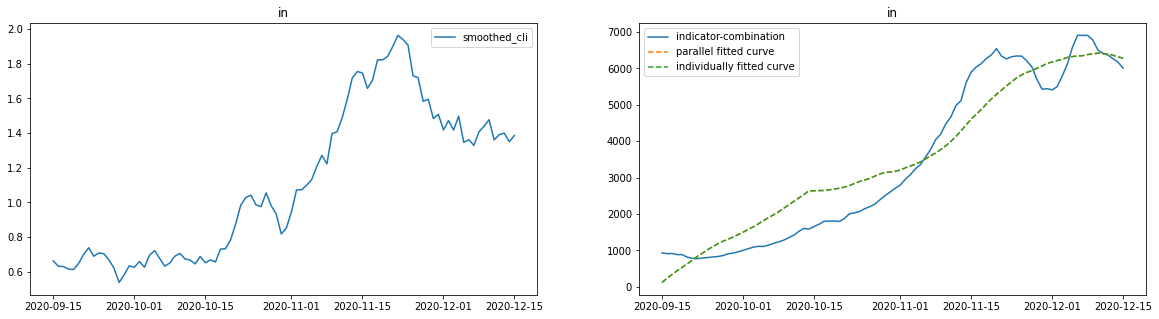

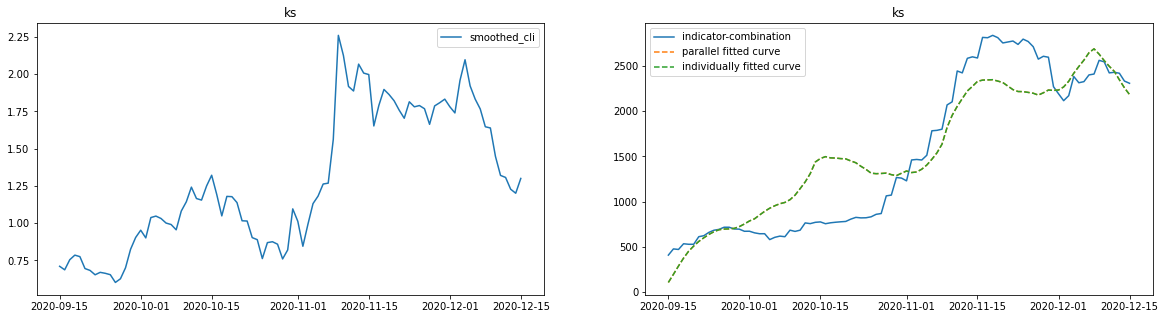

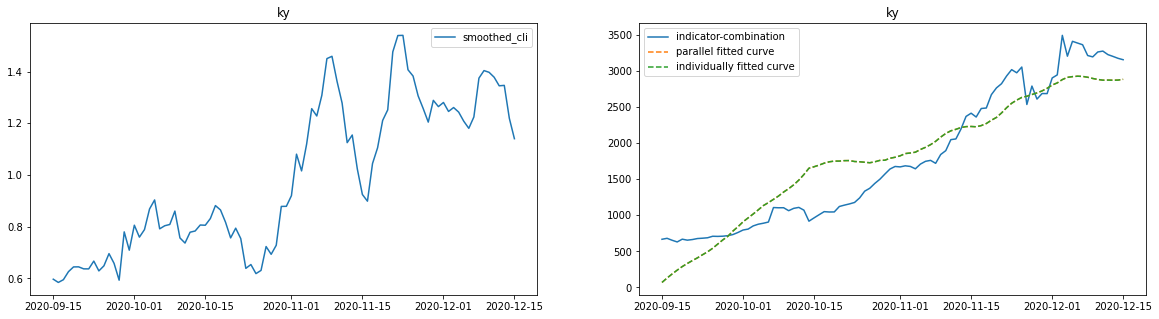

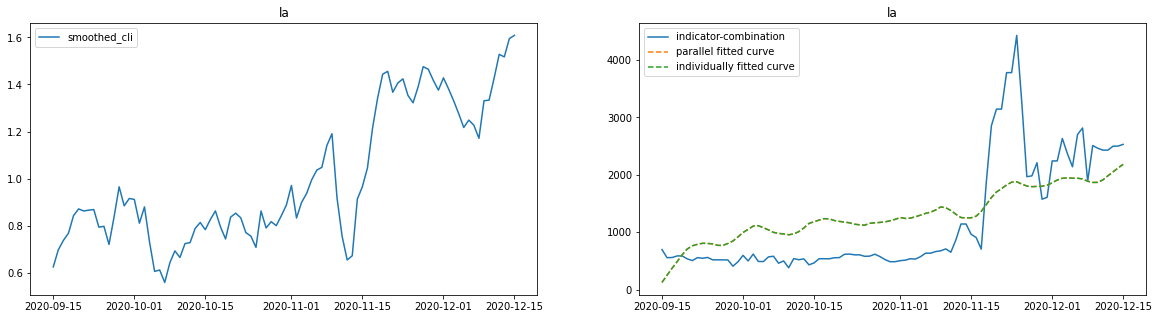

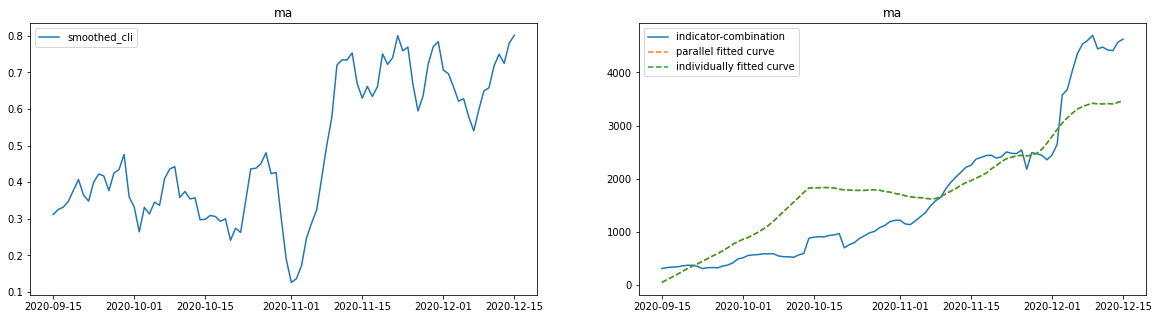

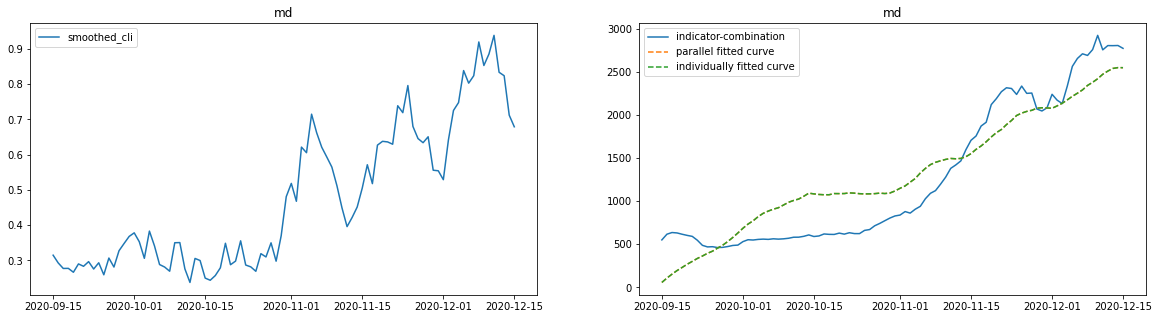

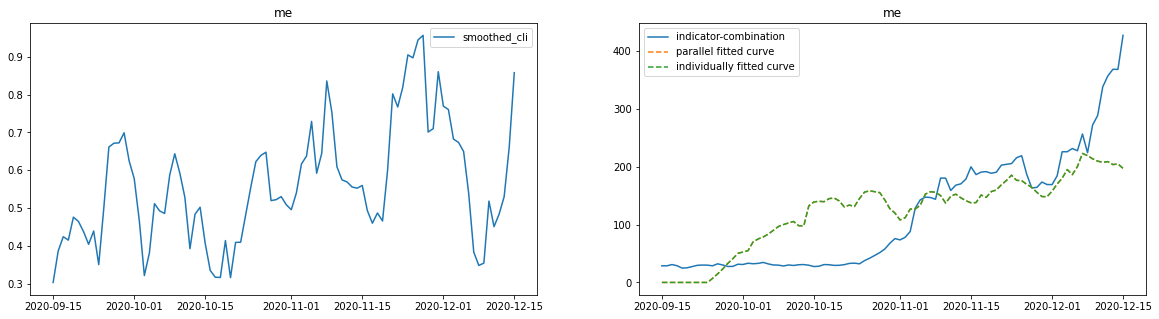

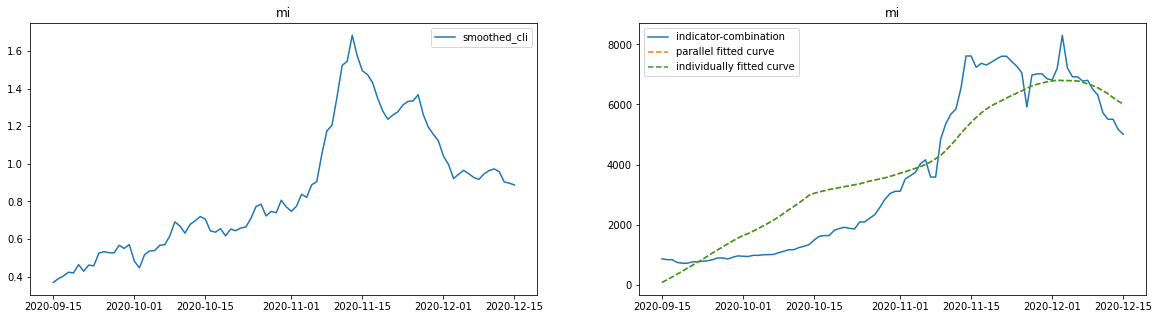

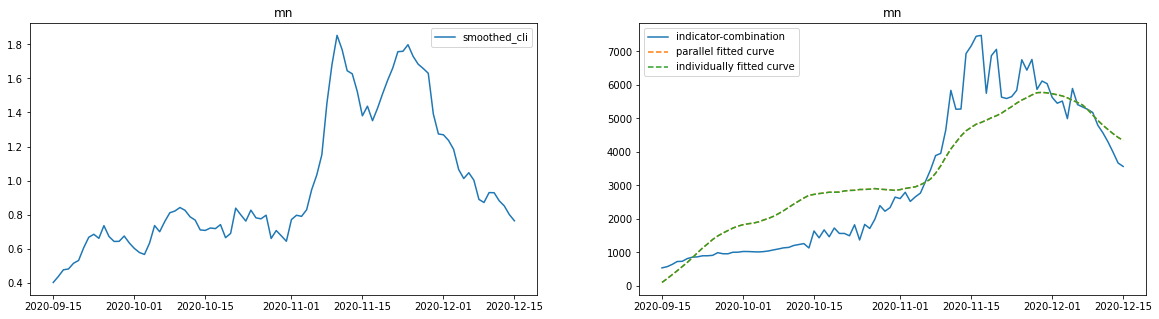

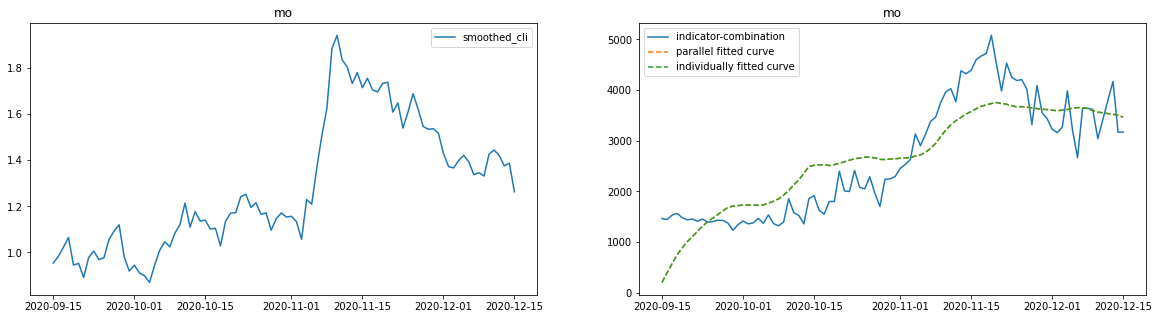

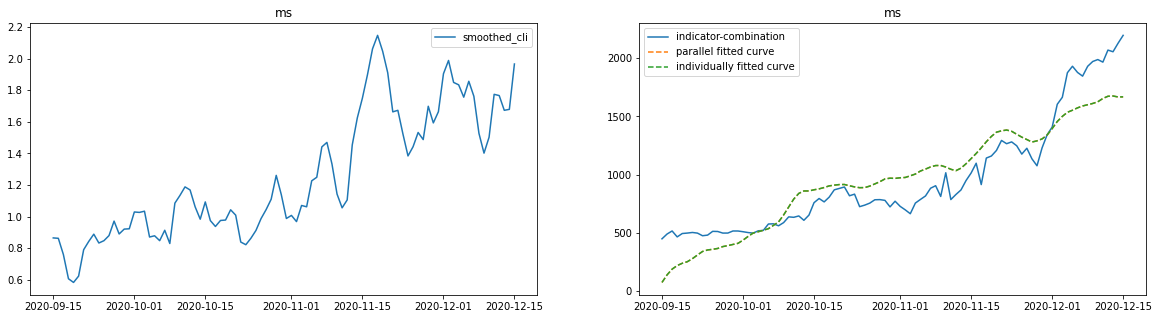

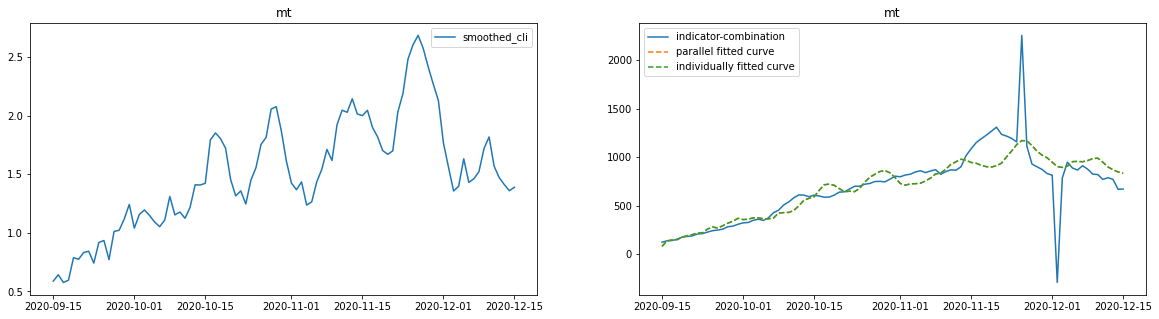

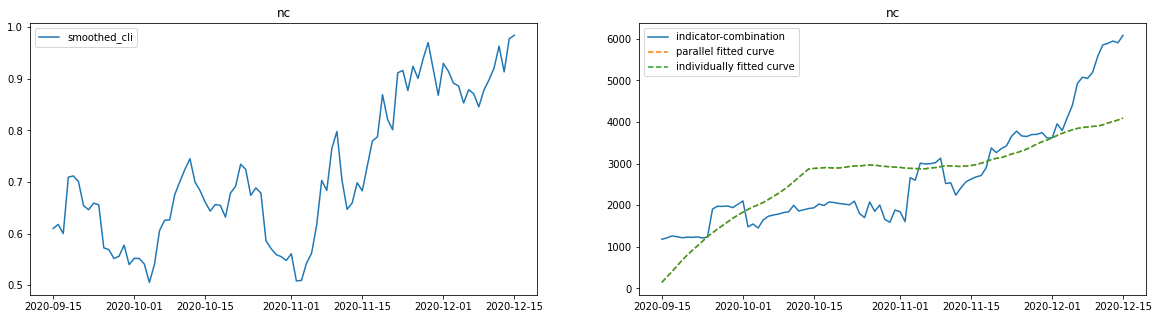

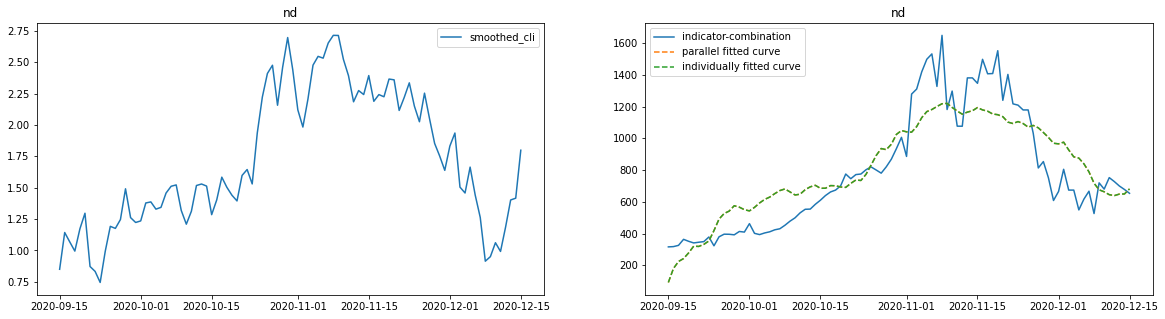

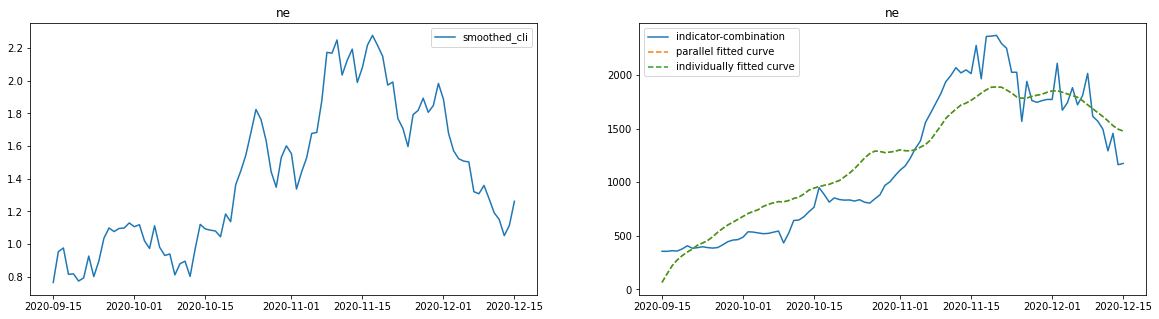

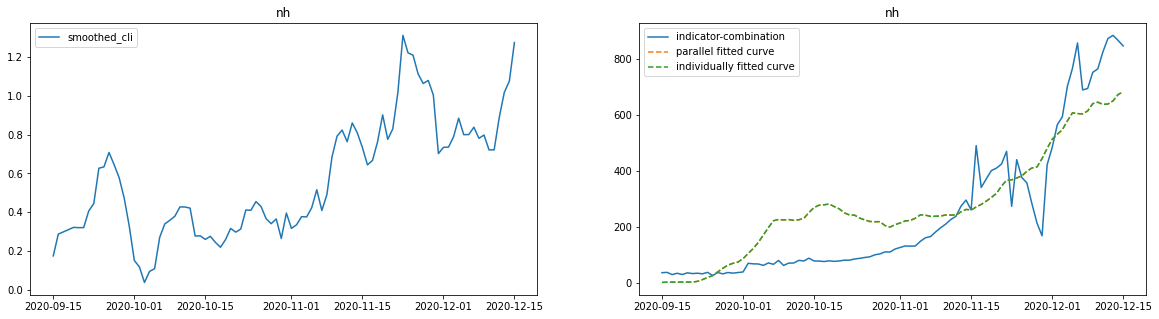

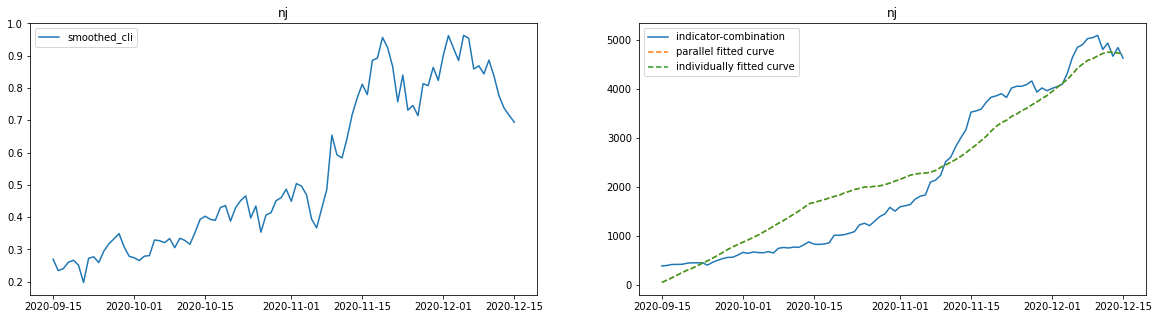

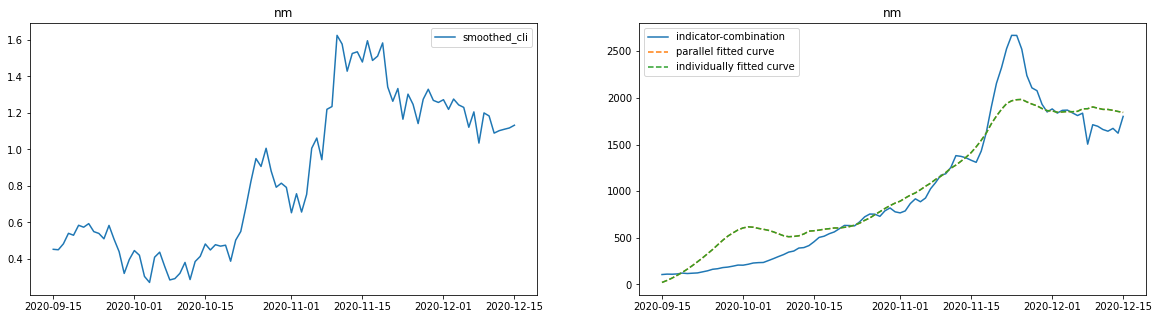

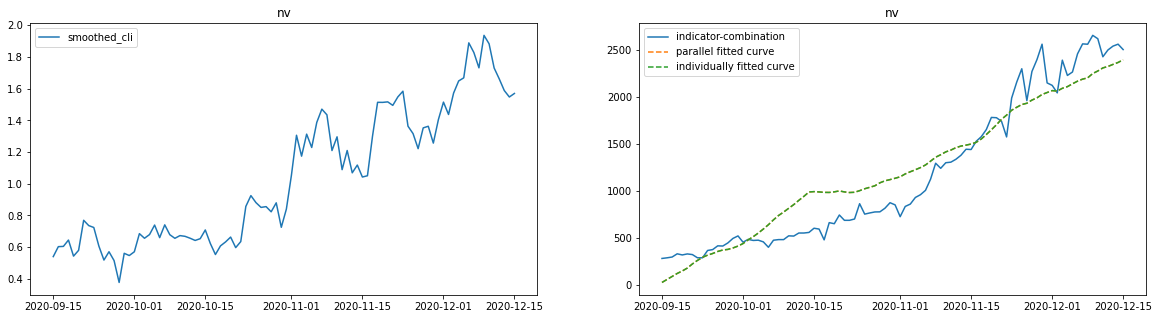

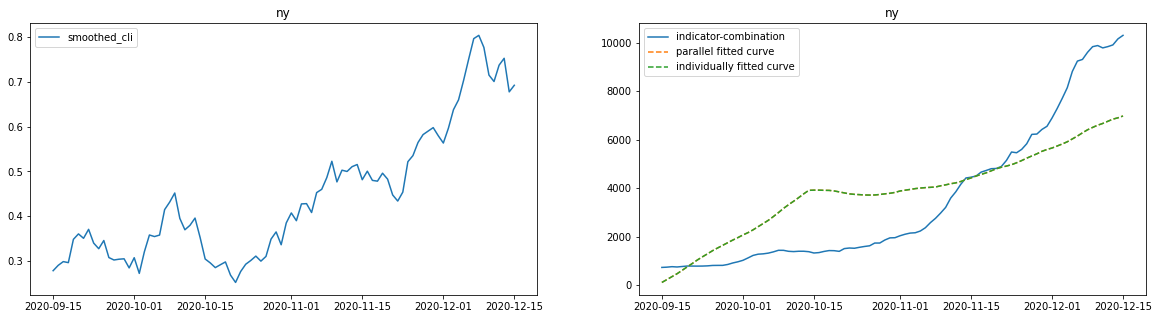

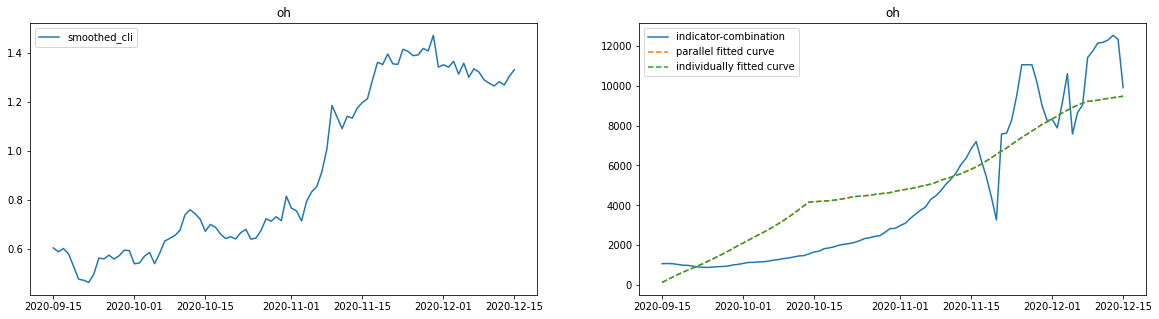

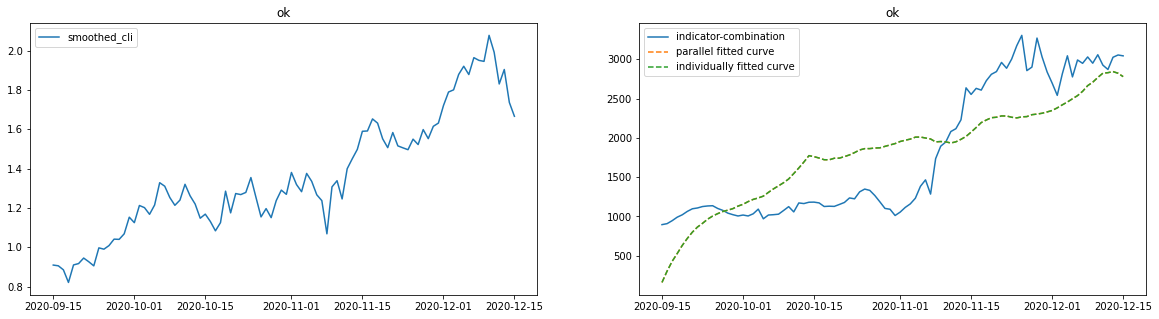

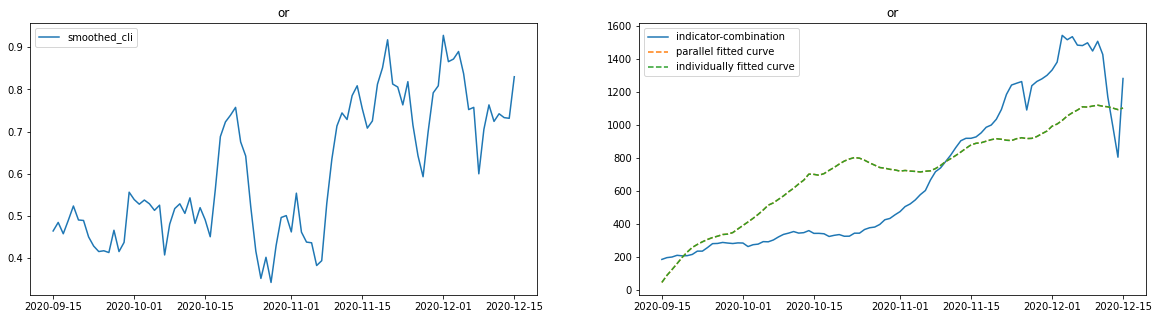

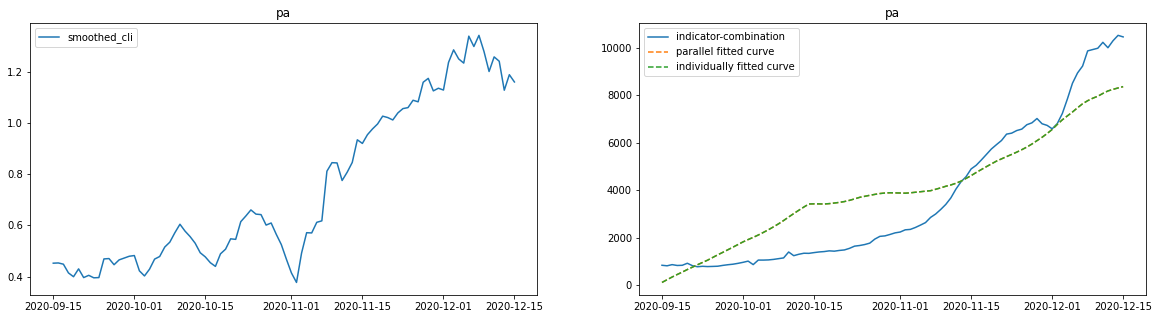

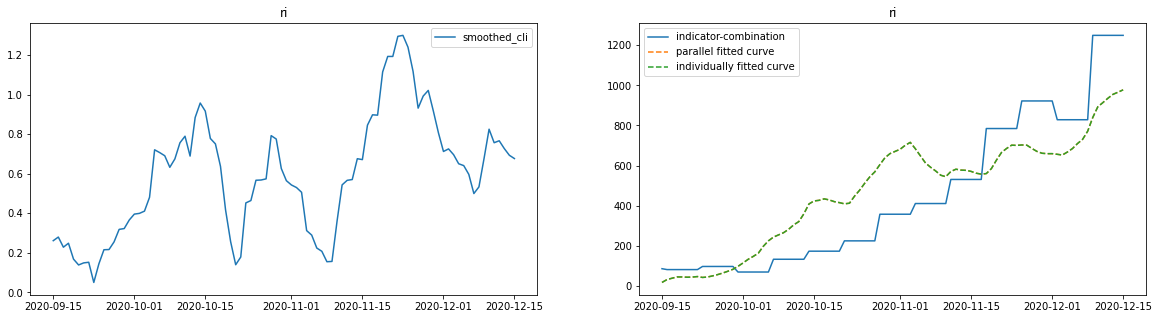

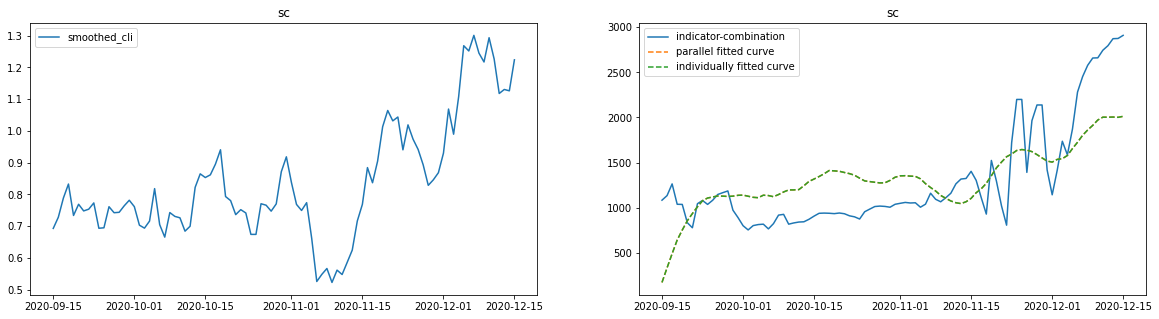

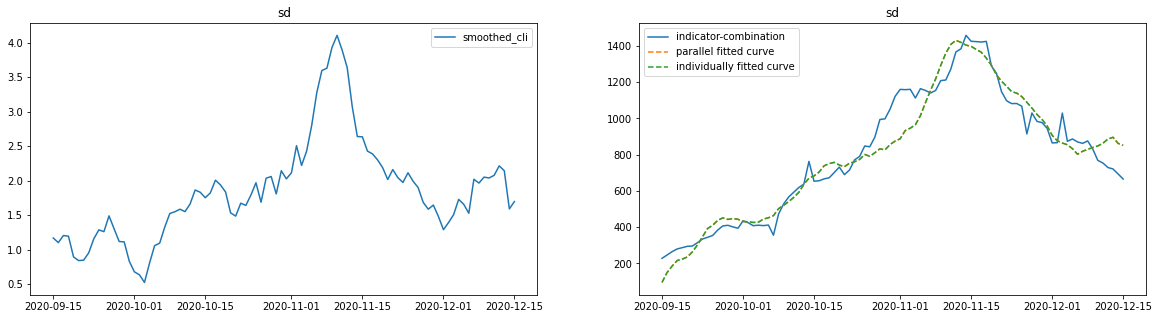

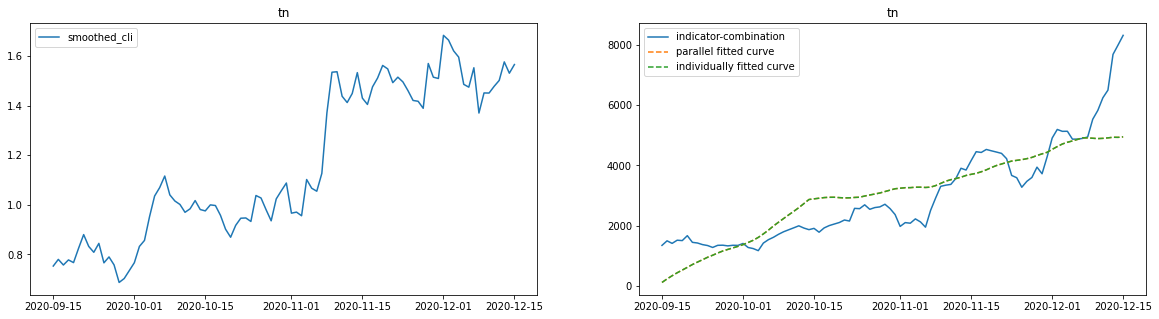

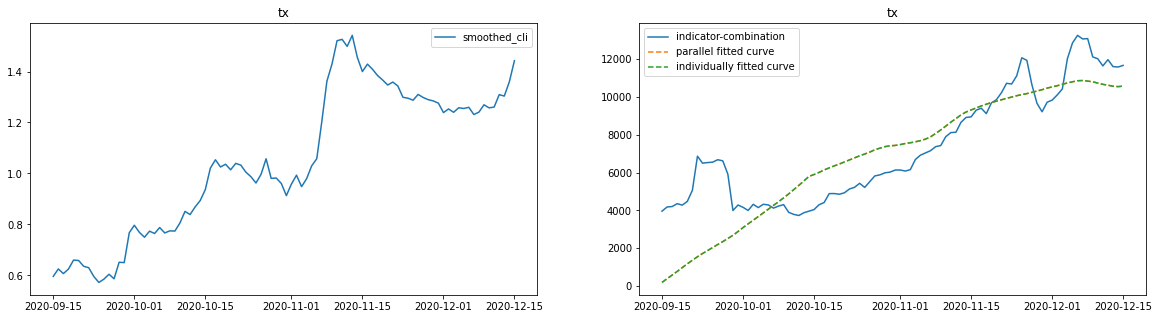

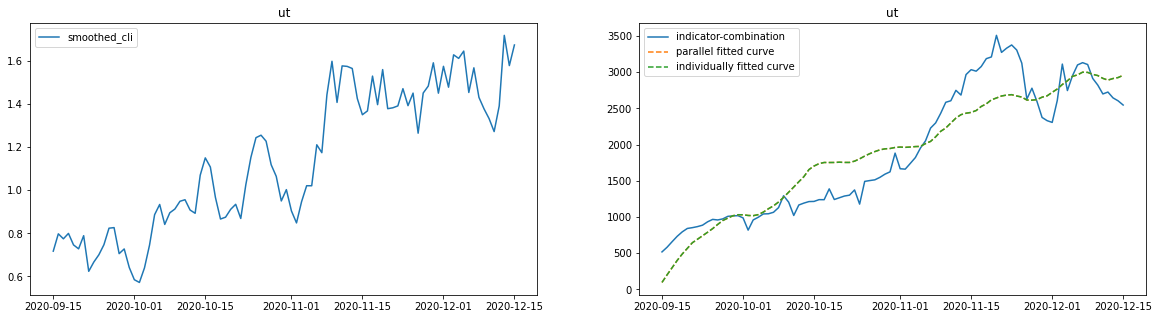

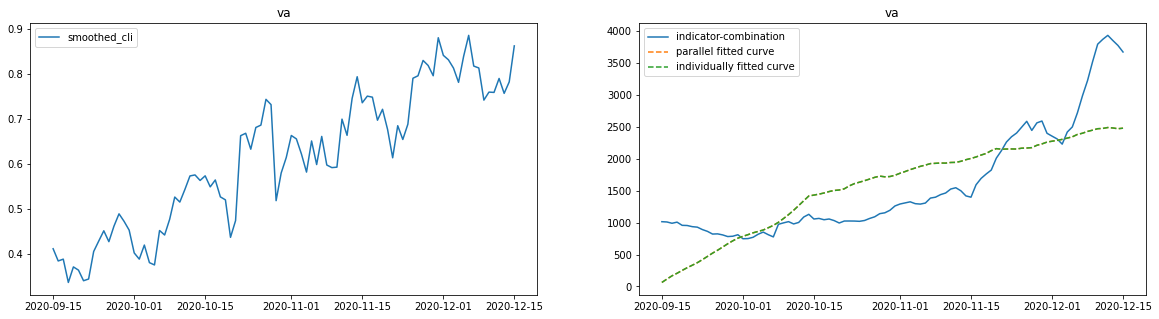

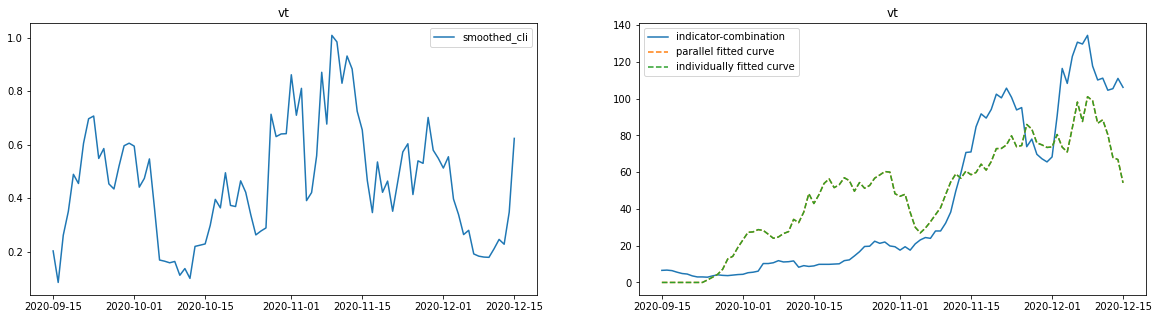

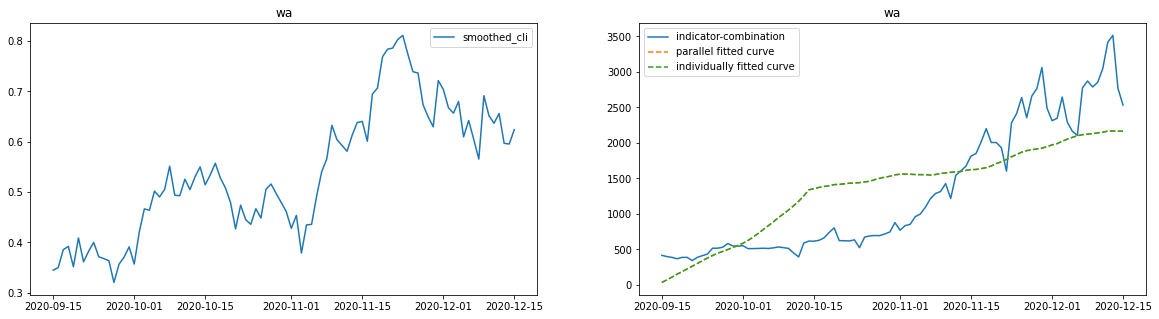

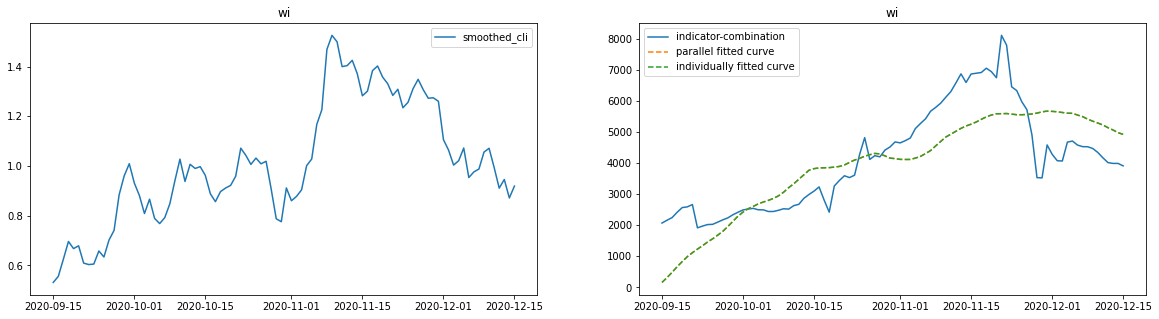

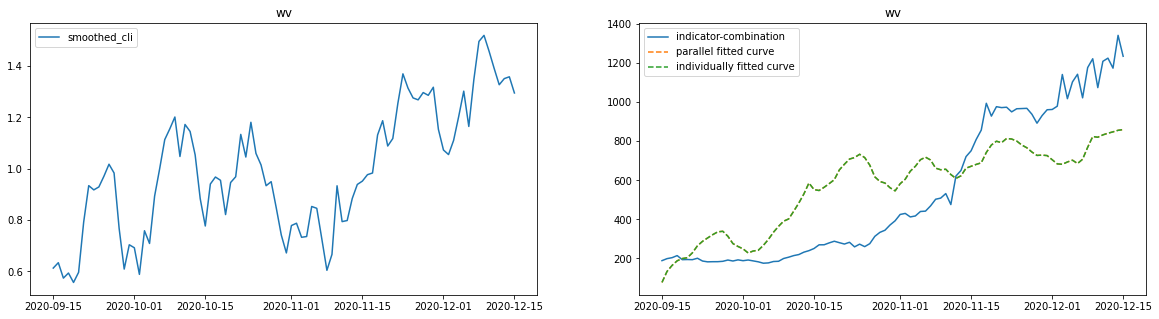

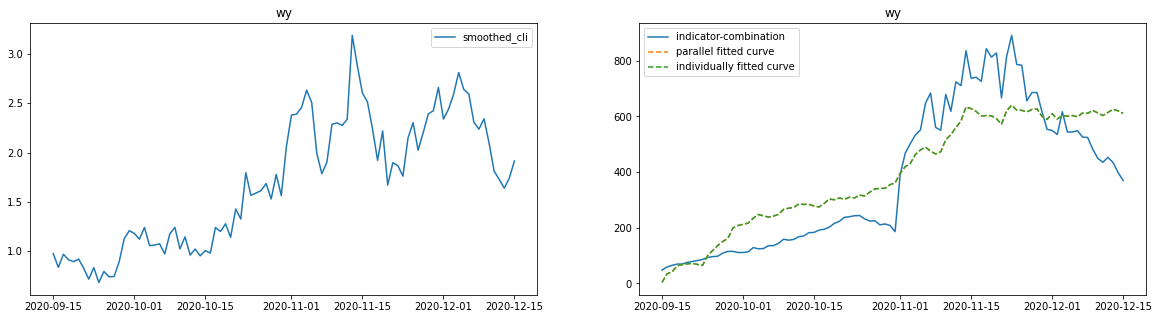

In [13]:
dates = X_df['time_value'].sort_values().unique()

for i in INDEXES:
    y = Y_df[Y_df['geo_value']==states[i]]['value']
    x = X_df[X_df['geo_value']==states[i]]['value']
    y_hat = Y_hat[0,:,i]
    y_hat_single = Y_hat_single[i][0,:,0]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

    ax[0].plot(dates, x, label='smoothed_cli')
    ax[0].legend()
    ax[0].set_title('{}'.format(states[i]))
    
    ax[1].plot(dates, y, label='indicator-combination')
    ax[1].plot(dates, y_hat, label='parallel fitted curve', linestyle='--')
    ax[1].plot(dates, y_hat_single, label='individually fitted curve', linestyle='--')
    ax[1].legend()
    ax[1].set_title('{}'.format(states[i]))
    
    plt.show()

# Check to see if convolutions are done in parallel, comparison of run times

In [14]:
cumulative_time = 0
for i in range(len(states)):
    X_single = X[:,:,i:i+1]
    Y_single = Y[:,:,i:i+1]
    #Initialize model

    #You can apply constraints directly to layers by setting
    #the kernel_constraints parameter for a specific layer
    #
    #https://www.tensorflow.org/api_docs/python/tf/keras/constraints
    p = 30
    m = X_single.shape[2] #number of geo_values
    kernel_constraint = tf.keras.constraints.NonNeg()
    kernel_regularizer = None
    lr = 1

    model = Model(
        p = p, 
        m = m,
        kernel_constraint = kernel_constraint,
        kernel_regularizer = kernel_regularizer,
    )
    optimizer = tf.keras.optimizers.Adam(lr = lr)

    def MSE(y_true, y_pred):
        return tf.reduce_mean((y_true-y_pred)**2)
    loss = MSE

    model.compile(
        optimizer = optimizer,
        loss = loss, 
        metrics = [loss],
    )
    #Training
    start = time.time()
    hist = model.fit(
        x = X_single,
        y = Y_single,
        epochs = 1000,
        verbose=0, #Set to 0 if you don't want to show progress bar, set to 1 if you do
    )
    cumulative_time += time.time()-start
print("Average elapsed time: {}".format(cumulative_time/len(states)))

Average elapsed time: 0.982291374206543


In [15]:
#Initialize model

#You can apply constraints directly to layers by setting
#the kernel_constraints parameter for a specific layer
#
#https://www.tensorflow.org/api_docs/python/tf/keras/constraints
p = 30
m = X.shape[2] #number of geo_values
kernel_constraint = tf.keras.constraints.NonNeg()
kernel_regularizer = None
lr = 1

model = Model(
    p = p, 
    m = m,
    kernel_constraint = kernel_constraint,
    kernel_regularizer = kernel_regularizer,
)
optimizer = tf.keras.optimizers.Adam(lr = lr)

def MSE(y_true, y_pred):
    return tf.reduce_mean((y_true-y_pred)**2)
loss = MSE

model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = [loss],
)

#Training
start=time.time()
hist = model.fit(
    x = X,
    y = Y,
    epochs = 1000,
    verbose=0, #Set to 0 if you don't want to show progress bar, set to 1 if you do
)
print(time.time()-start)

6.164116859436035


Training for 1000 epochs, the average training time for a single state is 0.982291374206543 seconds.

Training for 1000 epochs, the average training time for training all 50 states at once is 6.164116859436035

The convolutions still aren't being computed in parallel. You can make parallel calls with the keras functional API, but with the functional API you need to fix the size of the input, which isn't something we want to do. I'm figuring out some alternatives in the meantime.